<a href="https://colab.research.google.com/github/Hiroki-Kodama-PRS/Phantom-analysis/blob/main/Phantom_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np

# ===== 設定 =====
fs = 2000          # サンプリングレート [Hz]
window_sec = 1     # 窓の長さ [秒]

depths = [3, 9, 15, 21]
states = ["data1", "data2", "data3"]  # 実ファイル名に合わせて調整 (例: Normal, Ischaemia, Congestion)

records = []

# ===== データ読み込みと1秒ごとのAC/DC計算 =====
for depth in depths:
    for state in states:
        file = f"{depth}mm_adjusted_{state}.csv"
        df = pd.read_csv(file)
        for channel in ["ppgA_Red_raw", "ppgA_IR_raw"]:
            sig = df[channel].values
            step = fs * window_sec
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                ac = seg.max() - seg.min()     # 振幅（AC部分）
                mean_val = seg.mean()          # 平均値（DCの代表値）
                min_val = seg.min()            # 最小値（DCの代表値）
                records.append({
                    "Amplitude": ac,
                    "MeanValue": mean_val,
                    "MinValue": min_val,
                    "State": state,
                    "Depth": depth,
                    "Channel": "Red" if channel == "ppgA_Red_raw" else "IR"
                })

df_all = pd.DataFrame(records)

# ===== 正規化（各チャンネルのNormal=1基準） =====
# Normalをdata1と仮定しているので、必要に応じて置き換えてください
baseline = (
    df_all.query("State=='data1'")
    .groupby(["Channel", "Depth"])
    [["Amplitude","MeanValue","MinValue"]]
    .mean()
    .rename(columns={
        "Amplitude": "Amp_baseline",
        "MeanValue": "Mean_baseline",
        "MinValue": "Min_baseline"
    })
)

df_all = df_all.merge(
    baseline,
    on=["Channel", "Depth"],
    how="left"
)

df_all["Amp_norm"] = df_all["Amplitude"] / df_all["Amp_baseline"]
df_all["Mean_norm"] = df_all["MeanValue"] / df_all["Mean_baseline"]
df_all["Min_norm"] = df_all["MinValue"] / df_all["Min_baseline"]

# ===== 平均値テーブルを作成（状態×深さ×波長ごとの平均） =====
summary = (
    df_all
    .groupby(["Channel", "State", "Depth"])
    [["Amplitude","MeanValue","MinValue","Amp_norm","Mean_norm","Min_norm"]]
    .mean()
    .reset_index()
)

print("=== 各Channel×State×Depthの平均値 ===")
print(summary)

# ===== もしRed/IRそれぞれのNormalを1とした正規化テーブルをDepth×StateでPivot表示 =====
print("\n=== Amplitude normalized (Amp_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Amp_norm"))

print("\n=== MeanValue normalized (Mean_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Mean_norm"))

print("\n=== MinValue normalized (Min_norm) Pivot ===")
print(summary.pivot_table(index=["Channel","Depth"], columns="State", values="Min_norm"))


=== 各Channel×State×Depthの平均値 ===
   Channel  State  Depth  Amplitude  MeanValue  MinValue  Amp_norm  Mean_norm  \
0       IR  data1      3   0.006796   1.822378  1.818866  1.000000   1.000000   
1       IR  data1      9   0.004270   2.452707  2.450533  1.000000   1.000000   
2       IR  data1     15   0.002971   2.337707  2.336199  1.000000   1.000000   
3       IR  data1     21   0.002538   2.425896  2.424636  1.000000   1.000000   
4       IR  data2      3   0.005130   1.830351  1.827702  0.754839   1.004375   
5       IR  data2      9   0.003431   2.457375  2.455664  0.803594   1.001903   
6       IR  data2     15   0.002483   2.342253  2.341033  0.835793   1.001944   
7       IR  data2     21   0.002280   2.430329  2.429229  0.898488   1.001827   
8       IR  data3      3   0.005103   1.767454  1.764790  0.750806   0.969861   
9       IR  data3      9   0.004122   2.448920  2.446828  0.965340   0.998456   
10      IR  data3     15   0.002784   2.328764  2.327358  0.937269   0.99617

In [22]:
from scipy.signal import find_peaks

fs = 2000
signal = df[channel].values

# ピーク検出
peaks, _ = find_peaks(signal, prominence=0.001, distance=int(fs*0.3))

rise_times = []
fall_times = []
pulse_widths = []

for p in peaks:
    # ピークの前後で局所的な谷を探す
    # 例: ピーク±0.5秒の範囲で最小値を探す
    left = max(0, p - int(0.5*fs))
    right = min(len(signal), p + int(0.5*fs))
    seg = signal[left:right]
    # seg中の最大値=peak、最小値=baseline
    peak_idx = np.argmax(seg)
    trough_idx = np.argmin(seg[:peak_idx+1])  # 左側の谷
    next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])  # 右側の谷

    if trough_idx < peak_idx < next_trough_idx:
        rise = (peak_idx - trough_idx)/fs
        fall = (next_trough_idx - peak_idx)/fs
        baseline = seg[trough_idx]
        peak_val = seg[peak_idx]
        half = baseline + 0.5*(peak_val - baseline)
        # 半値幅
        above = np.where(seg[trough_idx:next_trough_idx] >= half)[0]
        pw = (above[-1] - above[0])/fs if len(above)>1 else np.nan

        rise_times.append(rise)
        fall_times.append(fall)
        pulse_widths.append(pw)

# ===== 結果をDataFrameにまとめる =====
df_features = pd.DataFrame({
    "RiseTime_s": rise_times,
    "FallTime_s": fall_times,
    "PulseWidth_s": pulse_widths
})

print(df_features.describe())
df_features.to_csv("pulse_features.csv", index=False)

       RiseTime_s  FallTime_s  PulseWidth_s
count    81.00000   81.000000     81.000000
mean      0.24284    0.390636      0.627586
std       0.13804    0.222362      0.197755
min       0.00650    0.006000      0.194000
25%       0.13150    0.231000      0.499000
50%       0.22900    0.431000      0.656000
75%       0.34900    0.549000      0.795500
max       0.63000    0.812500      0.953500


In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ========= パラメータ設定 =========
fs = 2000  # サンプリング周波数
depths = [3,9,15,21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red","ppgA_IR_raw":"IR"}

# ========= 1. 拍動特徴抽出関数 =========
def extract_pulse_features(signal, fs=2000, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs*dist))
    features = []
    for p in peaks:
        left = max(0, p - int(0.5*fs))
        right = min(len(signal), p + int(0.5*fs))
        seg = signal[left:right]
        if len(seg)<5: continue
        peak_idx = np.argmax(seg)
        trough_idx = np.argmin(seg[:peak_idx+1])
        next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])
        if trough_idx < peak_idx < next_trough_idx:
            rise = (peak_idx - trough_idx)/fs
            fall = (next_trough_idx - peak_idx)/fs
            baseline = seg[trough_idx]
            peak_val = seg[peak_idx]
            half = baseline + 0.5*(peak_val - baseline)
            above = np.where(seg[trough_idx:next_trough_idx] >= half)[0]
            pw = (above[-1] - above[0])/fs if len(above)>1 else np.nan
            amp = peak_val - baseline
            features.append((rise, fall, pw, amp))
    return features

# ========= 2. CSV読み込み＆特徴抽出 =========
records = []
for depth in depths:
    for state in state_map.keys():
        file = f"{depth}mm_adjusted_{state}.csv"
        df = pd.read_csv(file)
        for col,label in channels.items():
            feats = extract_pulse_features(df[col].values, fs)
            for r,f,pw,amp in feats:
                records.append({
                    "Depth": depth,
                    "State": state_map[state],
                    "Channel": label,
                    "RiseTime_s": r,
                    "FallTime_s": f,
                    "PulseWidth_s": pw,
                    "Amplitude": amp
                })

df_feat = pd.DataFrame(records)

# ========= 3. 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime_s"] / (df_feat["FallTime_s"]+1e-6)
df_feat["PW_amp_ratio"]   = df_feat["PulseWidth_s"] * df_feat["Amplitude"]

# Red と IR を結合して IR/Red 比を作成
# (同じDepth・State・インデックス近傍でマージする簡易的手法)
df_red = df_feat[df_feat.Channel=="Red"].reset_index()
df_ir  = df_feat[df_feat.Channel=="IR"].reset_index()
merged = pd.merge(df_red, df_ir, on=["Depth","State"], suffixes=("_Red","_IR"))
merged["IR_Red_amp_ratio"] = merged["Amplitude_IR"] / (merged["Amplitude_Red"]+1e-6)
# Redの行に対してIR/Redを追加（IRが無い場合はNaN）
df_feat = pd.merge(df_feat,
                   merged[["Depth","State","IR_Red_amp_ratio"]].drop_duplicates(),
                   on=["Depth","State"], how="left")

from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd

# ========= 4. ROC計算（ブートストラップCI付き） =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]
features_to_eval = [
    "RiseTime_s","FallTime_s","PulseWidth_s",
    "Amplitude","RiseFall_ratio","PW_amp_ratio","IR_Red_amp_ratio"
]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=1000, alpha=0.05):
    """AUCのブートストラップ95%CIを計算"""
    boot = []
    n = len(y_true)
    rng = np.random.default_rng(42)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)  # 置換つき再サンプリング
        if len(np.unique(y_true[idx])) < 2:
            continue
        boot.append(roc_auc_score(y_true[idx], y_score[idx]))
    if len(boot) == 0:
        return np.nan, np.nan, np.nan
    lower = np.percentile(boot, 2.5)
    upper = np.percentile(boot, 97.5)
    return np.mean(boot), lower, upper

results = []
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)]
        for feature in features_to_eval:
            if feature=="IR_Red_amp_ratio" and ch=="IR":
                continue
            # RedだけにIR/Red比を計算しているのでRed以外はスキップ
            for cls1,cls2 in pairs:
                df_sub = sub[sub.State.isin([cls1,cls2])]
                if len(df_sub)==0:
                    continue
                y_true = (df_sub.State==cls1).astype(int)
                y_score = df_sub[feature]
                if y_score.isna().any() or len(np.unique(y_true))<2:
                    continue
                try:
                    # 点推定と95%CI
                    auc_point = roc_auc_score(y_true, y_score)
                    auc_boot, ci_low, ci_up = bootstrap_auc_ci(y_true.values, y_score.values)

                    fpr,tpr,thr = roc_curve(y_true,y_score)
                    youden = tpr - fpr
                    idx = np.argmax(youden)

                    results.append({
                        "Channel":ch,
                        "Depth":depth,
                        "Feature":feature,
                        "Pair":f"{cls1} vs {cls2}",
                        "AUC":auc_point,
                        "AUC_bootstrap_mean": auc_boot,
                        "CI_lower": ci_low,
                        "CI_upper": ci_up,
                        "Cutoff":thr[idx],
                        "Sensitivity":tpr[idx],
                        "Specificity":1-fpr[idx]
                    })
                except Exception as e:
                    print(f"Error {ch} {depth} {feature} {cls1} vs {cls2}: {e}")

df_auc_feat = pd.DataFrame(results)
print("\n=== ROC サマリ (新特徴含む, ブートストラップCIあり) ===")
print(df_auc_feat.round(3))


# ========= 5. ROC 曲線プロット関数 =========
def plot_roc(df, ch, depth, feature, cls1, cls2):
    sub = df[(df.Channel==ch)&(df.Depth==depth)&(df.Pair==f"{cls1} vs {cls2}")&(df.Feature==feature)]
    if sub.empty:
        print("指定の組み合わせなし")
        return
    # 再計算
    data = df_feat[(df_feat.Channel==ch)&(df_feat.Depth==depth)&(df_feat.State.isin([cls1,cls2]))]
    y_true = (data.State==cls1).astype(int)
    y_score = data[feature]
    fpr,tpr,thr = roc_curve(y_true,y_score)
    auc = roc_auc_score(y_true,y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr,tpr,label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{ch} {depth}mm {feature}\n{cls1} vs {cls2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 例: Red 3mm でAmplitudeのROC
plot_roc(df_auc_feat, "Red", 3, "Amplitude", "Normal", "Congestion")

KeyboardInterrupt: 

In [ ]:
# === DataFrame全行をCSVに保存 ===
df_auc_feat.to_csv("ROC_summary_with_bootstrap.csv", index=False)

print("ROCサマリを 'ROC_summary_with_bootstrap.csv' として保存しました。")

ROCサマリを 'ROC_summary_with_bootstrap.csv' として保存しました。


Plotting ROC: IR 3mm Amplitude (Normal vs Congestion)


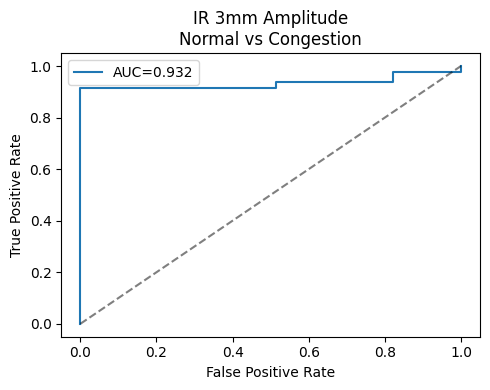

Plotting ROC: IR 3mm Amplitude (Normal vs Ischaemia)


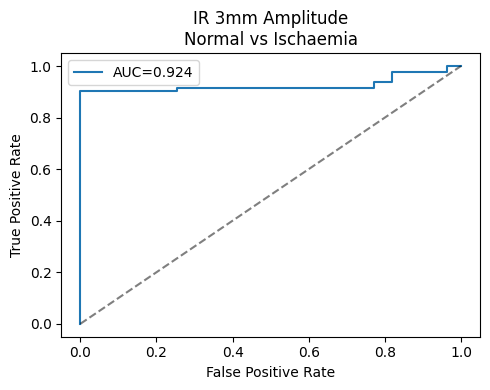

Plotting ROC: Red 3mm Amplitude (Normal vs Ischaemia)


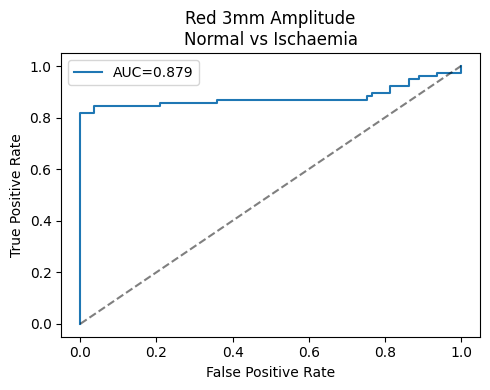

Plotting ROC: IR 9mm Amplitude (Normal vs Ischaemia)


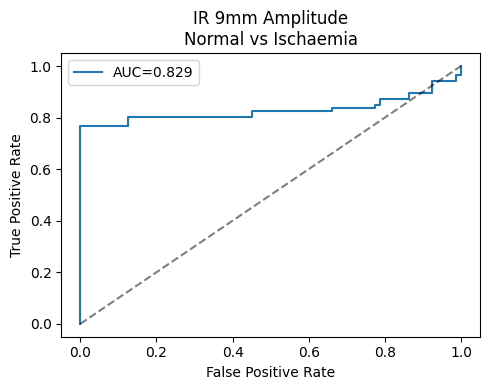

Plotting ROC: IR 15mm Amplitude (Normal vs Ischaemia)


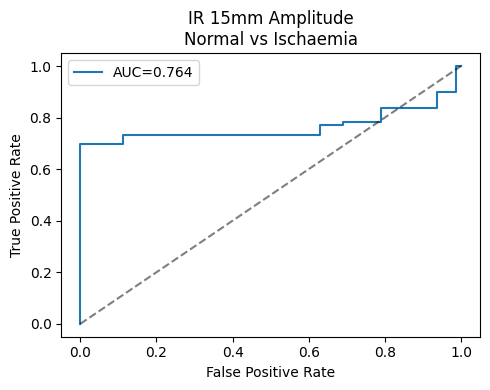

Plotting ROC: IR 9mm Amplitude (Normal vs Congestion)


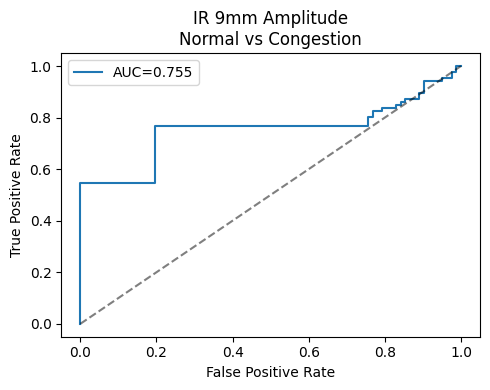

Plotting ROC: IR 15mm Amplitude (Normal vs Congestion)


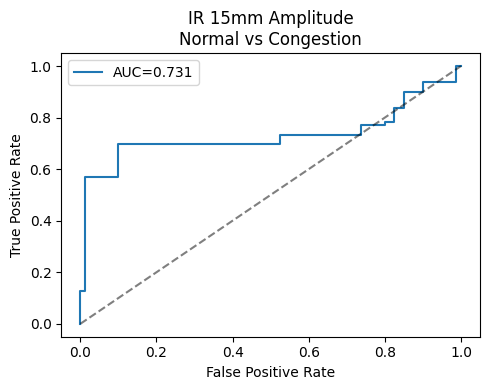

Plotting ROC: Red 3mm IR_Red_amp_ratio (Normal vs Congestion)


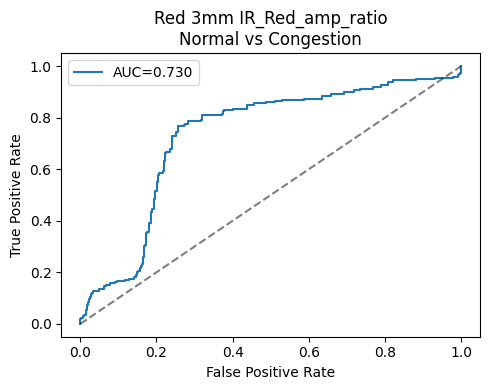

Plotting ROC: IR 3mm PW_amp_ratio (Normal vs Congestion)


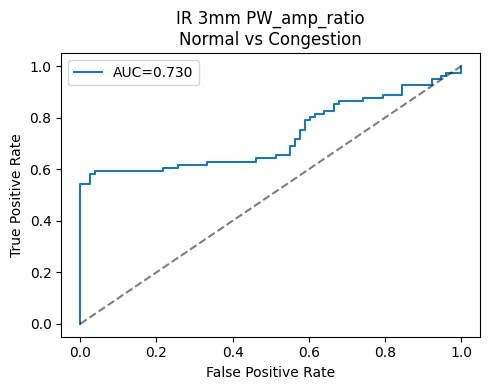

Plotting ROC: IR 3mm PW_amp_ratio (Normal vs Ischaemia)


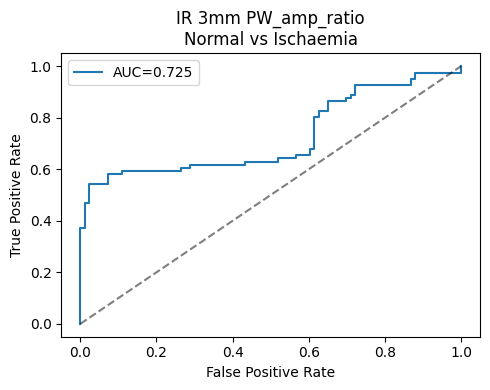

Plotting ROC: IR 21mm FallTime_s (Normal vs Ischaemia)


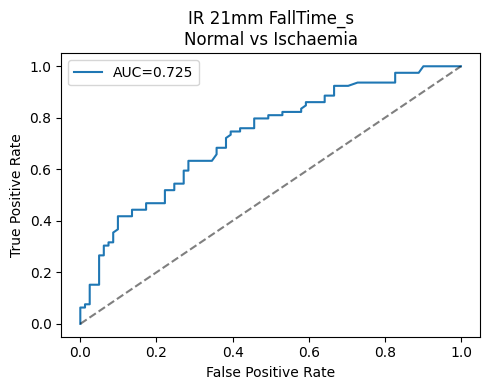

Plotting ROC: Red 9mm Amplitude (Normal vs Ischaemia)


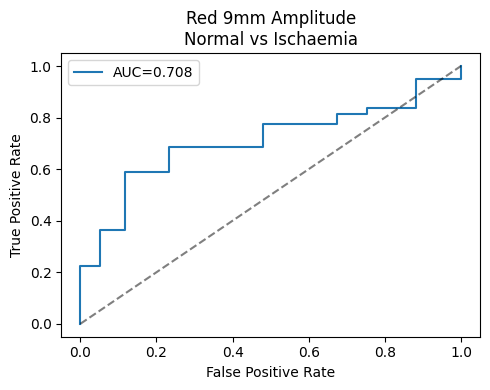

In [ ]:
import pandas as pd

roc_list = [
    ("IR",3,"Amplitude","Normal","Congestion"),
    ("IR",3,"Amplitude","Normal","Ischaemia"),
    ("Red",3,"Amplitude","Normal","Ischaemia"),
    ("IR",9,"Amplitude","Normal","Ischaemia"),
    ("IR",15,"Amplitude","Normal","Ischaemia"),
    ("IR",9,"Amplitude","Normal","Congestion"),
    ("IR",15,"Amplitude","Normal","Congestion"),
    ("Red",3,"IR_Red_amp_ratio","Normal","Congestion"),
    ("IR",3,"PW_amp_ratio","Normal","Congestion"),
    ("IR",3,"PW_amp_ratio","Normal","Ischaemia"),
    ("IR",21,"FallTime_s","Normal","Ischaemia"),
    ("Red",9,"Amplitude","Normal","Ischaemia"),
]

# === 一括でROCプロット ===
for ch, depth, feature, cls1, cls2 in roc_list:
    print(f"Plotting ROC: {ch} {depth}mm {feature} ({cls1} vs {cls2})")
    plot_roc(df_auc_feat, ch, depth, feature, cls1, cls2)


=== ブートストラップ AUC ===
   Channel  Depth                     Pair  AUC_bootstrap  CI_low  CI_high
0      Red      3      Normal vs Ischaemia          1.000   1.000    1.000
1      Red      3     Normal vs Congestion          0.728   0.592    0.840
2      Red      3  Ischaemia vs Congestion          0.002   0.000    0.010
3      Red      9      Normal vs Ischaemia          0.792   0.675    0.902
4      Red      9     Normal vs Congestion          0.541   0.383    0.692
5      Red      9  Ischaemia vs Congestion          0.317   0.181    0.459
6      Red     15      Normal vs Ischaemia          0.467   0.316    0.631
7      Red     15     Normal vs Congestion          0.541   0.387    0.693
8      Red     15  Ischaemia vs Congestion          0.482   0.325    0.631
9      Red     21      Normal vs Ischaemia          0.574   0.419    0.720
10     Red     21     Normal vs Congestion          0.511   0.365    0.662
11     Red     21  Ischaemia vs Congestion          0.361   0.223    0.498
12 

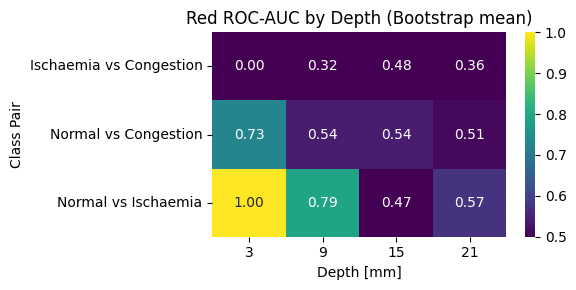


=== IR AUC (bootstrap mean) ===
Depth                       3      9      15     21
Pair                                               
Ischaemia vs Congestion  0.722  0.000  0.062  0.241
Normal vs Congestion     1.000  0.903  0.956  0.778
Normal vs Ischaemia      1.000  0.999  1.000  0.830


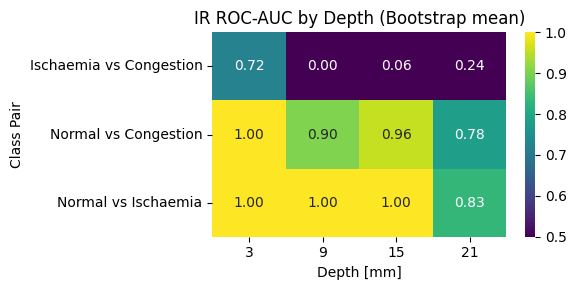

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 設定 =====
fs = 2000          # サンプリングレート [Hz]
window_sec = 1     # 窓の長さ [秒]

depths = [3, 9, 15, 21]
states = ["data1", "data2", "data3"]  # 実ファイル名に合わせて調整 (例: Normal, Ischaemia, Congestion)

records = []

# ===== データ読み込み =====
state_map = {"data1":"Normal", "data2":"Ischaemia", "data3":"Congestion"}

for depth in depths:
    for state in states:
        file = f"{depth}mm_adjusted_{state}.csv"
        df = pd.read_csv(file)
        for channel in ["ppgA_Red_raw", "ppgA_IR_raw"]:
            sig = df[channel].values
            step = fs * window_sec
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                ac = seg.max() - seg.min()
                mean_val = seg.mean()
                min_val = seg.min()
                records.append({
                    "Amplitude": ac,
                    "MeanValue": mean_val,
                    "MinValue": min_val,
                    "State": state_map[state],   # ←ここで変換
                    "Depth": depth,
                    "Channel": "Red" if "Red" in channel else "IR"
                })


df_all = pd.DataFrame(records)

# ===== 正規化（各チャンネルのNormal=1基準） =====
# Normalをdata1と仮定しているので、必要に応じて置き換えてください
baseline = (
    df_all.query("State=='data1'")
    .groupby(["Channel", "Depth"])
    [["Amplitude","MeanValue","MinValue"]]
    .mean()
    .rename(columns={
        "Amplitude": "Amp_baseline",
        "MeanValue": "Mean_baseline",
        "MinValue": "Min_baseline"
    })
)

df_all = df_all.merge(
    baseline,
    on=["Channel", "Depth"],
    how="left"
)

df_all["Amp_norm"] = df_all["Amplitude"] / df_all["Amp_baseline"]
df_all["Mean_norm"] = df_all["MeanValue"] / df_all["Mean_baseline"]
df_all["Min_norm"] = df_all["MinValue"] / df_all["Min_baseline"]

# ===== 平均値テーブルを作成（状態×深さ×波長ごとの平均） =====
summary = (
    df_all
    .groupby(["Channel", "State", "Depth"])
    [["Amplitude","MeanValue","MinValue","Amp_norm","Mean_norm","Min_norm"]]
    .mean()
    .reset_index()
)


# ====== ブートストラップ AUC 計算関数 ======
def bootstrap_auc(y_true, y_score, n_bootstrap=1000, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    if len(aucs)==0:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 100*alpha/2), np.percentile(aucs, 100*(1-alpha/2))

# ====== AUC集計（Amplitudeのみ） ======
states = ["Normal","Ischaemia","Congestion"]
pairs = [("Normal","Ischaemia"), ("Normal","Congestion"), ("Ischaemia","Congestion")]
channels = ["Red","IR"]

records_bs = []
for ch in channels:
    for depth in sorted(df_all.Depth.unique()):
        sub = df_all[(df_all.Channel==ch) & (df_all.Depth==depth)]
        if sub.empty:
            continue
        # Amp_norm をAmplitudeに置き換える場合は "Amplitude" 列
        # もしすでにAmp_normがあるならそちらを使う
        # 今回はAmplitudeを使用
        feature = "Amplitude"
        for cls1, cls2 in pairs:
            df_sub = sub[sub.State.isin([cls1,cls2])]
            if df_sub.empty:
                continue
            y_true = (df_sub.State==cls1).astype(int).values
            y_score = df_sub[feature].values
            if len(np.unique(y_true)) < 2:
                continue
            auc_mean, ci_lo, ci_hi = bootstrap_auc(y_true, y_score)
            records_bs.append({
                "Channel": ch,
                "Depth": depth,
                "Pair": f"{cls1} vs {cls2}",
                "AUC_bootstrap": auc_mean,
                "CI_low": ci_lo,
                "CI_high": ci_hi
            })

df_auc_bs = pd.DataFrame(records_bs)
print("\n=== ブートストラップ AUC ===")
print(df_auc_bs.round(3))

# ====== ヒートマップ作成 ======
for ch in channels:
    pivot = df_auc_bs[df_auc_bs.Channel==ch].pivot(index="Pair", columns="Depth", values="AUC_bootstrap")
    print(f"\n=== {ch} AUC (bootstrap mean) ===")
    print(pivot.round(3))
    plt.figure(figsize=(6,3))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis", vmin=0.5, vmax=1)
    plt.title(f"{ch} ROC-AUC by Depth (Bootstrap mean)")
    plt.ylabel("Class Pair")
    plt.xlabel("Depth [mm]")
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ========= パラメータ =========
fs = 2000           # サンプリングレート [Hz]
window_sec = 1      # 1秒ごとに分割
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
channels = {"ppgA_Red_raw": "Red", "ppgA_IR_raw": "IR"}

# ========= 1. データ読み込み & 振幅計算 =========
records = []
for depth in depths:
    for key, state in state_map.items():
        file = f"{depth}mm_adjusted_{key}.csv"
        df = pd.read_csv(file)
        for col, label in channels.items():
            sig = df[col].values
            step = fs * window_sec
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w*step, (w+1)*step
                seg = sig[s:e]
                if len(seg) < 5: 
                    continue
                amp = seg.max() - seg.min()
                mean = seg.mean()
                records.append({
                    "Depth": depth,
                    "State": state,
                    "Channel": label,
                    "Amplitude": amp,
                    "MeanValue": mean
                })

df_all = pd.DataFrame(records)

# ========= 2. 正規化（Normal 3mm Red を基準にする） =========
# Normal 3mm Red の平均Amplitudeで全体をスケーリング
baseline_amp = df_all.query("State=='Normal' and Depth==3 and Channel=='Red'")["Amplitude"].mean()
df_all["Amp_norm"] = df_all["Amplitude"] / baseline_amp

# ========= 3. AUC計算（ブートストラップCI付き） =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=200, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    if not aucs:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 100*alpha/2), np.percentile(aucs, 100*(1-alpha/2))

results = []
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_all[(df_all.Channel==ch)&(df_all.Depth==depth)]
        for cls1, cls2 in pairs:
            df_sub = sub[sub.State.isin([cls1,cls2])]
            if df_sub.empty: 
                continue
            y_true = (df_sub.State==cls1).astype(int).values
            y_score = df_sub["Amp_norm"].values
            if len(np.unique(y_true)) < 2: 
                continue
            auc = roc_auc_score(y_true, y_score)
            auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)
            fpr, tpr, thr = roc_curve(y_true, y_score)
            youden = tpr - fpr
            idx = np.argmax(youden)
            results.append({
                "Channel": ch,
                "Depth": depth,
                "Pair": f"{cls1} vs {cls2}",
                "AUC": auc,
                "AUC_bootstrap_mean": auc_bs,
                "CI_lower": ci_lo,
                "CI_upper": ci_hi,
                "Cutoff": thr[idx],
                "Sensitivity": tpr[idx],
                "Specificity": 1-fpr[idx]
            })

df_auc = pd.DataFrame(results)
print("\n=== ROC サマリ (Amplitude, bootstrapあり) ===")
print(df_auc.round(3))

# ========= 4. ROC 曲線プロット =========
def plot_roc(ch, depth, cls1, cls2):
    data = df_all[(df_all.Channel==ch)&(df_all.Depth==depth)&(df_all.State.isin([cls1,cls2]))]
    if data.empty:
        print("データなし")
        return
    y_true = (data.State==cls1).astype(int)
    y_score = data["Amp_norm"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{ch} {depth}mm {cls1} vs {cls2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === DataFrame全行をCSVに保存 ===
df_auc.to_csv("ROC_summary_with_bootstrap.csv", index=False)
print("ROCサマリを 'ROC_summary_with_bootstrap.csv' として保存しました。")


=== ROC サマリ (Amplitude, bootstrapあり) ===
   Channel  Depth                     Pair    AUC  AUC_bootstrap_mean  \
0      Red      3      Normal vs Ischaemia  1.000               1.000   
1      Red      3     Normal vs Congestion  0.729               0.730   
2      Red      3  Ischaemia vs Congestion  0.002               0.002   
3      Red      9      Normal vs Ischaemia  0.794               0.784   
4      Red      9     Normal vs Congestion  0.543               0.537   
5      Red      9  Ischaemia vs Congestion  0.319               0.321   
6      Red     15      Normal vs Ischaemia  0.466               0.468   
7      Red     15     Normal vs Congestion  0.540               0.546   
8      Red     15  Ischaemia vs Congestion  0.480               0.495   
9      Red     21      Normal vs Ischaemia  0.570               0.576   
10     Red     21     Normal vs Congestion  0.510               0.506   
11     Red     21  Ischaemia vs Congestion  0.360               0.361   
12      I

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, detrend, butter, filtfilt
import matplotlib.pyplot as plt

# ========= パラメータ設定 =========
fs = 2000
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}

# --- バンドパスフィルタ（0.5-5Hz 心拍成分のみ残す） ---
def bandpass_filter(sig, fs, low=0.5, high=5.0, order=3):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, sig)

# --- IRからピーク検出 ---
def detect_beats(signal, fs=2000, dist=0.5):
    sig = detrend(signal)
    sig = bandpass_filter(sig, fs)
    prom = np.std(sig) * 0.6   # 標準偏差ベースのprominence
    peaks, _ = find_peaks(sig, prominence=prom, distance=int(fs*dist))
    bpm = len(peaks) / (len(signal)/fs/60)
    beats = [(peaks[i], peaks[i+1]) for i in range(len(peaks)-1)]
    return beats, bpm

# --- IRで得た拍動区間をRedにも適用して特徴抽出 ---
def extract_features_using_ir(ir_sig, red_sig, fs):
    beats, bpm = detect_beats(ir_sig, fs)
    feats = []
    for start, end in beats:
        seg_ir = ir_sig[start:end]
        seg_red = red_sig[start:end]

        # IR amplitude
        ir_amp = seg_ir.max() - seg_ir.min() if len(seg_ir) > 5 else np.nan

        # Red amplitude & temporal features
        if len(seg_red) > 5:
            red_amp = seg_red.max() - seg_red.min()
            red_baseline = seg_red.min()
            red_peak = seg_red.max()
            rise = (np.argmax(seg_red) - np.argmin(seg_red[:np.argmax(seg_red)+1])) / fs
            fall = (len(seg_red) - np.argmax(seg_red)) / fs
            half = red_baseline + 0.5*(red_peak - red_baseline)
            above = np.where(seg_red >= half)[0]
            pw = (above[-1] - above[0])/fs if len(above) > 1 else np.nan
        else:
            red_amp = np.nan; rise = np.nan; fall = np.nan; pw = np.nan

        feats.append((ir_amp, red_amp, rise, fall, pw))
    return feats, bpm

# ========= データ処理 =========
records = []

for depth in depths:
    for key, state in state_map.items():
        df = pd.read_csv(f"{depth}mm_adjusted_{key}.csv")
        ir_sig = df["ppgA_IR_raw"].values
        red_sig = df["ppgA_Red_raw"].values

        feats, bpm = extract_features_using_ir(ir_sig, red_sig, fs)
        if len(feats) == 0:
            print(f"⚠️ No beats detected: {depth}mm {state}")
        for ir_amp, red_amp, rise, fall, pw in feats:
            # IR
            records.append({
                "Depth": depth, "State": state, "Channel": "IR",
                "Amplitude": ir_amp, "RiseTime_s": np.nan,
                "FallTime_s": np.nan, "PulseWidth_s": np.nan,
                "bpm": bpm
            })
            # Red
            records.append({
                "Depth": depth, "State": state, "Channel": "Red",
                "Amplitude": red_amp, "RiseTime_s": rise,
                "FallTime_s": fall, "PulseWidth_s": pw,
                "bpm": bpm
            })

df_feat = pd.DataFrame(records)

# ========= 正規化 =========
# RedはRed 3mm Normal基準, IRはIR 3mm Normal基準
baseline_red = df_feat.query("Channel=='Red' & Depth==3 & State=='Normal'")["Amplitude"].mean()
baseline_ir  = df_feat.query("Channel=='IR'  & Depth==3 & State=='Normal'")["Amplitude"].mean()

df_feat["Amp_norm"] = df_feat.apply(
    lambda x: x["Amplitude"]/baseline_red if x["Channel"]=="Red" else x["Amplitude"]/baseline_ir,
    axis=1
)

# ========= 複合指標 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime_s"] / (df_feat["FallTime_s"]+1e-6)
df_feat["PW_amp_ratio"]   = df_feat["PulseWidth_s"] * df_feat["Amplitude"]

# ========= bpm 確認 =========
print("\n=== bpm summary ===")
print(df_feat.groupby(["Depth","State"])["bpm"].mean().round(1))


ValueError: array must not contain infs or NaNs

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score, roc_curve

# ========= 基本設定 =========
fs = 2000  # Hz
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
channels = {"ppgA_Red_raw": "Red", "ppgA_IR_raw": "IR"}

# bpmテーブル（ユーザー提供値）
bpm_table = {
    3:  {"Normal": 60.8, "Ischaemia": 60.8, "Congestion": 62.3},
    9:  {"Normal": 62.7, "Ischaemia": 64.7, "Congestion": 64.3},
    15: {"Normal": 60.4, "Ischaemia": 60.8, "Congestion": 60.8},
    21: {"Normal": 65.1, "Ischaemia": 63.2, "Congestion": 63.2},
}

# ========= 拍動特徴抽出関数 =========
def extract_pulse_features(signal, fs, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs * dist))
    feats = []
    for p in peaks:
        left = max(0, p - int(0.5 * fs))
        right = min(len(signal), p + int(0.5 * fs))
        seg = signal[left:right]
        if len(seg) < 5:
            continue
        peak_idx = np.argmax(seg)
        trough_idx = np.argmin(seg[:peak_idx+1])
        next_trough_idx = peak_idx + np.argmin(seg[peak_idx:])
        if trough_idx < peak_idx < next_trough_idx:
            rise = (peak_idx - trough_idx) / fs
            fall = (next_trough_idx - peak_idx) / fs
            baseline = seg[trough_idx]
            peak_val = seg[peak_idx]
            half = baseline + 0.5 * (peak_val - baseline)
            above = np.where(seg[trough_idx:next_trough_idx] >= half)[0]
            pw = (above[-1] - above[0]) / fs if len(above) > 1 else np.nan
            amp = peak_val - baseline
            feats.append((rise, fall, pw, amp))
    return feats

# ========= データ読み込み & 特徴抽出 =========
records = []
for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_adjusted_data{i_state}.csv")
        df = pd.read_csv(file)
        bpm = bpm_table[depth][state_name]
        window_sec = 60.0 / bpm
        step = int(round(fs * window_sec))

        for col, ch_label in channels.items():
            sig = df[col].values
            # ---- (1) 1拍ごとのAmplitude計算 ----
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                if len(seg) < 5:
                    continue
                amp = seg.max() - seg.min()
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "RiseTime_s": np.nan, "FallTime_s": np.nan,
                    "PulseWidth_s": np.nan, "Amplitude": amp
                })
            # ---- (2) find_peaksで特徴抽出 ----
            feats = extract_pulse_features(sig, fs)
            for r, f, pw, amp in feats:
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "RiseTime_s": r, "FallTime_s": f,
                    "PulseWidth_s": pw, "Amplitude": amp
                })

df_feat = pd.DataFrame(records)

# ========= 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime_s"] / (df_feat["FallTime_s"] + 1e-6)
df_feat["PW_amp_ratio"]   = df_feat["PulseWidth_s"] * df_feat["Amplitude"]

# ========= IR/Red比 (Amp_normではなくAmplitudeから計算) =========
df_red = df_feat[df_feat.Channel=="Red"].reset_index(drop=True)
df_ir  = df_feat[df_feat.Channel=="IR"].reset_index(drop=True)
merged = pd.merge(
    df_red[["Depth","State","Amplitude"]],
    df_ir[["Depth","State","Amplitude"]],
    on=["Depth","State"],
    suffixes=("_Red","_IR")
)
merged["IR_Red_amp_ratio"] = merged["Amplitude_IR"] / (merged["Amplitude_Red"] + 1e-6)
df_feat = pd.merge(
    df_feat,
    merged[["Depth","State","IR_Red_amp_ratio"]],
    on=["Depth","State"],
    how="left"
)

# ========= 正規化（RedはRed3mm Normal, IRはIR3mm Normal） =========
def normalize_channel(df, ch):
    base = df.query("Channel==@ch and Depth==3 and State=='Normal'")["Amplitude"].mean()
    df.loc[df.Channel == ch, "Amp_norm"] = df.loc[df.Channel == ch, "Amplitude"] / base

normalize_channel(df_feat, "Red")
normalize_channel(df_feat, "IR")

# ========= ROC AUC計算 (ブートストラップ付) =========
pairs = [("Normal", "Ischaemia"), ("Normal", "Congestion"), ("Ischaemia", "Congestion")]
features_to_eval = ["Amplitude", "RiseTime_s", "FallTime_s", "PulseWidth_s", "RiseFall_ratio", "PW_amp_ratio", "IR_Red_amp_ratio"]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=50, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    if len(aucs) == 0:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)

rows = []
for ch in ["Red", "IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel == ch) & (df_feat.Depth == depth)]
        if sub.empty:
            continue
        for feature in features_to_eval:
            if feature == "IR_Red_amp_ratio" and ch == "IR":
                continue
            for cls1, cls2 in pairs:
                d = sub[sub.State.isin([cls1, cls2])]
                if d.empty:
                    continue

                # --- NaN 除外 ---
                y_true = (d["State"] == cls1).astype(int).values
                y_score = d[feature].values
                mask = ~np.isnan(y_score)
                y_true = y_true[mask]
                y_score = y_score[mask]
                if len(y_true) == 0 or len(np.unique(y_true)) < 2:
                    continue

                auc_point = roc_auc_score(y_true, y_score)
                auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)

                fpr, tpr, thr = roc_curve(y_true, y_score)
                youden = tpr - fpr
                idx = np.argmax(youden)
                cutoff = thr[idx]
                sens = tpr[idx]
                spec = 1 - fpr[idx]

                rows.append({
                    "Channel": ch,
                    "Depth": depth,
                    "Feature": feature,
                    "Pair": f"{cls1} vs {cls2}",
                    "AUC": auc_point,
                    "AUC_bootstrap_mean": auc_bs,
                    "CI_lower": ci_lo,
                    "CI_upper": ci_hi,
                    "Cutoff": cutoff,
                    "Sensitivity": sens,
                    "Specificity": spec,
                    "n_samples": len(y_true)
                })

df_auc_feat = pd.DataFrame(rows)
df_auc_feat.to_csv("AUC_all_features_95CI.csv", index=False)
print("Saved AUC_all_features_95CI.csv")
print(df_auc_feat.round(3).head())


Saved AUC_all_features_95CI.csv
  Channel  Depth     Feature                     Pair    AUC  \
0     Red      3   Amplitude      Normal vs Ischaemia  0.910   
1     Red      3   Amplitude     Normal vs Congestion  0.635   
2     Red      3   Amplitude  Ischaemia vs Congestion  0.097   
3     Red      3  RiseTime_s      Normal vs Ischaemia  0.463   
4     Red      3  RiseTime_s     Normal vs Congestion  0.475   

   AUC_bootstrap_mean  CI_lower  CI_upper  Cutoff  Sensitivity  Specificity  \
0               0.910     0.909     0.910   0.005        0.862        1.000   
1               0.635     0.634     0.635   0.005        0.606        0.703   
2               0.097     0.097     0.098     inf        0.000        1.000   
3               0.463     0.462     0.463   0.110        0.910        0.192   
4               0.475     0.474     0.476   0.170        0.679        0.412   

   n_samples  
0    2744511  
1    2733946  
2    2745827  
3    1963962  
4    1963410  


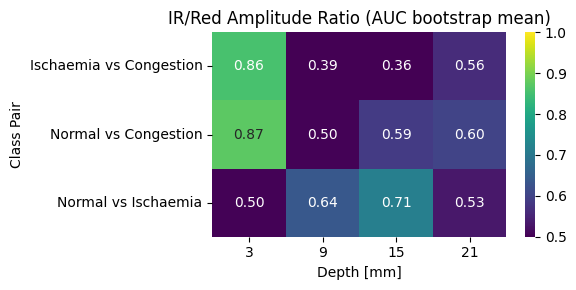

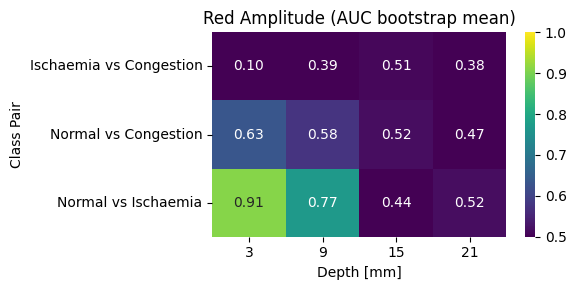

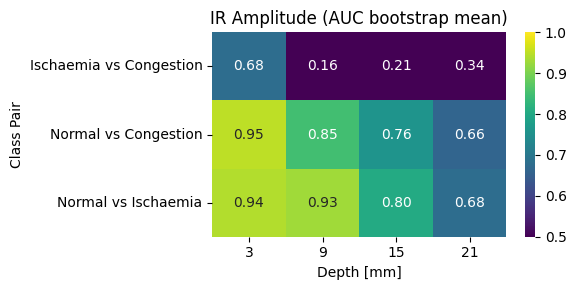

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==== データ読み込み ====
df = pd.read_csv("AUC_all_features_95CI.csv")  # ←先ほど作ったAUC結果CSVを指定

# ---- 可視化対象の特徴ごとのDataFrameを準備 ----
# 1. IR_Red_amp_ratio（Redチャンネルでのみ計算されている）
df_ratio = df[(df["Feature"]=="IR_Red_amp_ratio") & (df["Channel"]=="Red")]

# 2. Red Amplitude
df_red_amp = df[(df["Feature"]=="Amplitude") & (df["Channel"]=="Red")]

# 3. IR Amplitude
df_ir_amp = df[(df["Feature"]=="Amplitude") & (df["Channel"]=="IR")]

def plot_heatmap(df_sub, title):
    """指定したデータフレームをヒートマップにする"""
    if df_sub.empty:
        print(f"{title} のデータがありません")
        return
    pivot = df_sub.pivot(index="Pair", columns="Depth", values="AUC_bootstrap_mean")
    plt.figure(figsize=(6, 3))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis", vmin=0.5, vmax=1)
    plt.title(title)
    plt.ylabel("Class Pair")
    plt.xlabel("Depth [mm]")
    plt.tight_layout()
    plt.show()

# ==== プロット ====
plot_heatmap(df_ratio, "IR/Red Amplitude Ratio (AUC bootstrap mean)")
plot_heatmap(df_red_amp, "Red Amplitude (AUC bootstrap mean)")
plot_heatmap(df_ir_amp, "IR Amplitude (AUC bootstrap mean)")

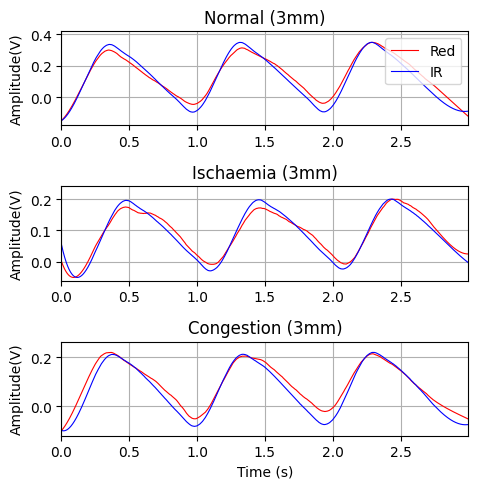

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ========= 設定 =========
fs = 2000  # サンプリングレート [Hz]
start_time = 11    # 開始秒
display_time = 3  # 表示秒数
depth = 3         # 3mmのみ
channels = {"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"}
states = [("Normal", 1), ("Ischaemia", 2), ("Congestion", 3)]

# 状態ごとの正規化レンジ（min, max）
normalize_ranges = {
    "Normal":    (-0.15, 0.35),
    "Ischaemia": (-0.05, 0.20),
    "Congestion":(-0.10, 0.22)
}

plt.figure(figsize=(5, 5))

for idx, (state_name, state_idx) in enumerate(states, start=1):
    # データ読み込み
    file = f"{depth}mm_adjusted_data{state_idx}.csv"
    df = pd.read_csv(file)

    # RedとIRの信号
    red = df[channels["Red"]].values
    ir = df[channels["IR"]].values

    # 開始時間以降で最も近いminを探す
    start_index = int(start_time * fs)
    search_window = red[start_index:start_index + fs*2]  # 開始5sから7sくらいまで検索窓
    min_offset = np.argmin(search_window)
    min_index = start_index + min_offset

    # min_indexからdisplay_time分切り出し
    end_index = min_index + int(display_time * fs)
    t = np.arange(min_index, end_index) / fs - (min_index / fs)  # min時刻をt=0にする
    red_seg = red[min_index:end_index]
    ir_seg = ir[min_index:end_index]

    # Savitzky-Golayフィルタで平滑化
    red_smooth = savgol_filter(red_seg, 1001, 3)
    ir_smooth = savgol_filter(ir_seg, 1001, 3)

    # ---- Normalization ----
    y_min, y_max = normalize_ranges[state_name]
    # Red
    red_norm = (red_smooth - red_smooth.min()) / (red_smooth.max() - red_smooth.min() + 1e-9)
    red_norm = red_norm * (y_max - y_min) + y_min
    # IR
    ir_norm = (ir_smooth - ir_smooth.min()) / (ir_smooth.max() - ir_smooth.min() + 1e-9)
    ir_norm = ir_norm * (y_max - y_min) + y_min

    # プロット
    ax = plt.subplot(len(states), 1, idx)
    ax.plot(t, red_norm, label="Red", color='red', linewidth=0.8)
    ax.plot(t, ir_norm, label="IR", color='blue', linewidth=0.8)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)  # min位置

    ax.set_xlim([t[0], t[-1]])
    ax.set_ylim([y_min*1.2, y_max*1.2])
    ax.set_ylabel("Amplitude(V)")
    ax.set_title(f"{state_name} (3mm)")
    ax.grid(True)

    if idx == len(states):
        ax.set_xlabel("Time (s)")

    if idx == 1:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


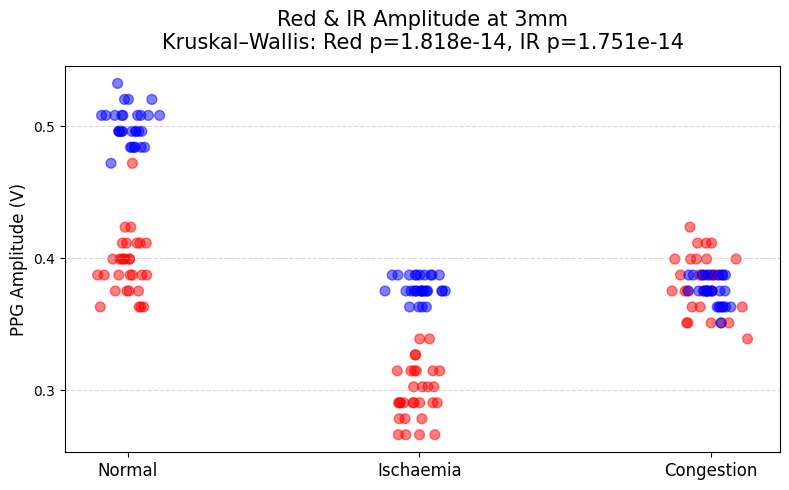

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import matplotlib.ticker as ticker

# ========= 設定 =========
fs = 2000        # サンプリングレート [Hz]
window_sec = 1   # 1拍分を近似する窓 (1秒)
files = [
    ("3mm_adjusted_data1.csv", "Normal"),
    ("3mm_adjusted_data2.csv", "Ischaemia"),
    ("3mm_adjusted_data3.csv", "Congestion"),
]

# ========= 振幅データ抽出 =========
red_groups = []
ir_groups  = []
labels = []

for file, label in files:
    df = pd.read_csv(file)
    red = df["ppgA_Red_raw"].values
    ir  = df["ppgA_IR_raw"].values

    step = fs * window_sec
    n_win = len(red) // step

    red_amp = []
    ir_amp  = []
    for w in range(n_win):
        s = w * step
        e = s + step
        rseg = red[s:e]
        iseg = ir[s:e]
        if len(rseg) < 2 or len(iseg) < 2:
            continue
        red_amp.append(rseg.max() - rseg.min())
        ir_amp.append( iseg.max() - iseg.min())

    red_groups.append(red_amp)
    ir_groups.append(ir_amp)
    labels.append(label)

# ========= Normal IR の平均を 0.5 にスケーリング =========
normal_ir_mean = np.mean(ir_groups[0])
scale_factor = 0.5 / normal_ir_mean

red_groups_scaled = [[v * scale_factor for v in g] for g in red_groups]
ir_groups_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

# ========= Kruskal-Wallis検定 =========
stat_red, p_red = kruskal(*red_groups_scaled)
stat_ir,  p_ir  = kruskal(*ir_groups_scaled)

# ========= 可視化 =========
plt.figure(figsize=(8,5))

for i, label in enumerate(labels):
    # Red と IR を同じ列上に置く（微小な jitter だけ）
    x_jitter = np.random.normal(i, 0.05, len(red_groups_scaled[i] + ir_groups_scaled[i]))
    # Red と IR を結合した振幅
    y_vals = np.concatenate([red_groups_scaled[i], ir_groups_scaled[i]])
    # 色分け用の配列
    colors = ["red"] * len(red_groups_scaled[i]) + ["blue"] * len(ir_groups_scaled[i])
    plt.scatter(x_jitter, y_vals, c=colors, alpha=0.5, s=50)

plt.xticks(range(len(labels)), labels, fontsize=12)
plt.ylabel("PPG Amplitude (V)", fontsize=12)
plt.title(f"Red & IR Amplitude at 3mm\n"
          f"Kruskal–Wallis: Red p={p_red:.3e}, IR p={p_ir:.3e}",
          fontsize=15, pad=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)

# 縦軸を0.1刻みに設定
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.tight_layout()
plt.show()


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import matplotlib.ticker as ticker

# ========= 設定 =========
fs = 2000        # サンプリングレート [Hz]
window_sec = 1   # 1拍分を近似する窓 (1秒)
files = [
    ("3mm_adjusted_data1.csv", "Normal"),
    ("3mm_adjusted_data2.csv", "Ischaemia"),
    ("3mm_adjusted_data3.csv", "Congestion"),
]

# ========= 振幅データ抽出 =========
red_groups = []
ir_groups  = []
labels = []

for file, label in files:
    df = pd.read_csv(file)
    red = df["ppgA_Red_raw"].values
    ir  = df["ppgA_IR_raw"].values

    step = int(round(fs * window_sec))  # ★ float→intに修正
    n_win = len(red) // step

    red_amp = []
    ir_amp  = []
    for w in range(n_win):
        s = w * step
        e = s + step
        rseg = red[s:e]
        iseg = ir[s:e]
        if len(rseg) < 2 or len(iseg) < 2:
            continue
        red_amp.append(rseg.max() - rseg.min())
        ir_amp.append(iseg.max() - iseg.min())

    red_groups.append(red_amp)
    ir_groups.append(ir_amp)
    labels.append(label)

# ========= Normal IR の平均を 0.5 にスケーリング =========
normal_ir_mean = np.mean(ir_groups[0])
scale_factor = 0.5 / normal_ir_mean

red_groups_scaled = [[v * scale_factor for v in g] for g in red_groups]
ir_groups_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

# ========= Kruskal-Wallis検定 =========
stat_red, p_red = kruskal(*red_groups_scaled)
stat_ir,  p_ir  = kruskal(*ir_groups_scaled)

# ========= 統計結果の表を作成 =========
df_stats = pd.DataFrame([
    {"Comparison": "Red", "Chi-Squared": stat_red, "df": len(red_groups_scaled)-1, "p-Value": p_red},
    {"Comparison": "IR",  "Chi-Squared": stat_ir,  "df": len(ir_groups_scaled)-1,  "p-Value": p_ir}
])
print("\n=== Kruskal–Wallis 検定結果 ===")
print(df_stats.round(4))

# CSVに保存する場合
df_stats.to_csv("kruskal_results_3mm.csv", index=False)



=== Kruskal–Wallis 検定結果 ===
  Comparison  Chi-Squared  df  p-Value
0        Red      63.2773   2      0.0
1         IR      63.3525   2      0.0


In [67]:
pip install scikit-posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 18.2 MB/s eta 0:00:00a 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 18.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [70]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm

# ===== データ: red_groups_scaled, ir_groups_scaled が既にある前提 =====
# red_groups_scaled = [Normal群の値リスト, Ischaemia群の値リスト, Congestion群の値リスト]
# ir_groups_scaled   = 同様にIRの値リスト

group_names = ["Normal", "Ischaemia", "Congestion"]

def dunn_test(groups, group_labels):
    """
    groups: [array_like, array_like, ...]
    group_labels: list of group names
    return: DataFrame (Comparison, Z, p, p_adj)
    """
    # すべての値を結合し rank 付け
    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i,g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)
    ties_correction = 1 - (np.sum(np.bincount(ranks.astype(int))[1:]**3 - np.bincount(ranks.astype(int))[1:]) / (n**3 - n))
    if ties_correction <= 0: ties_correction = 1

    # 各群の情報
    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id==i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i]/n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt( (n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction )
            Z = diff / SE
            p = 2*(1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{group_labels[i]} vs {group_labels[j]}",
                "Z": Z,
                "p_Unadj": p
            })

    df = pd.DataFrame(results)
    # Bonferroni 補正
    df["p_Adj"] = np.minimum(df["p_Unadj"] * len(df), 1.0)
    return df

# ==== Red の Dunn test ====
df_dunn_red = dunn_test(red_groups_scaled, group_names)
df_dunn_red.insert(1, "Channel", "Red")

# ==== IR の Dunn test ====
df_dunn_ir = dunn_test(ir_groups_scaled, group_names)
df_dunn_ir.insert(1, "Channel", "IR")

# ==== 結合 ====
df_dunn = pd.concat([df_dunn_red, df_dunn_ir], ignore_index=True)

print("\n=== Dunn post-hoc test (Z, p, Bonferroni) ===")
print(df_dunn.round(4))

# 保存
df_dunn.to_csv("dunn_posthoc_Z.csv", index=False)
print("✅ Dunn test結果を 'dunn_posthoc_Z.csv' に保存しました")



=== Dunn post-hoc test (Z, p, Bonferroni) ===
                Comparison Channel       Z  p_Unadj   p_Adj
0      Normal vs Ischaemia     Red  7.6802   0.0000  0.0000
1     Normal vs Congestion     Red  2.0461   0.0407  0.1222
2  Ischaemia vs Congestion     Red -5.6341   0.0000  0.0000
3      Normal vs Ischaemia      IR  5.6742   0.0000  0.0000
4     Normal vs Congestion      IR  7.6710   0.0000  0.0000
5  Ischaemia vs Congestion      IR  1.9968   0.0458  0.1375
✅ Dunn test結果を 'dunn_posthoc_Z.csv' に保存しました


                       File       Channel  AC_DC  Autocorr  DomFreq_Hz  \
0    3mm_adjusted_data1.csv  ppgA_Red_raw  0.004     0.831         1.0   
1    3mm_adjusted_data1.csv   ppgA_IR_raw  0.004     0.867         1.0   
2    3mm_adjusted_data2.csv  ppgA_Red_raw  0.002     0.711         1.0   
3    3mm_adjusted_data2.csv   ppgA_IR_raw  0.004     0.805         1.0   
4    3mm_adjusted_data3.csv  ppgA_Red_raw  0.004     0.873         1.0   
5    3mm_adjusted_data3.csv   ppgA_IR_raw  0.004     0.835         1.0   
6    9mm_adjusted_data1.csv  ppgA_Red_raw  0.002     0.479         1.0   
7    9mm_adjusted_data1.csv   ppgA_IR_raw  0.002     0.792         1.0   
8    9mm_adjusted_data2.csv  ppgA_Red_raw  0.001     0.337        50.0   
9    9mm_adjusted_data2.csv   ppgA_IR_raw  0.002     0.569         1.0   
10   9mm_adjusted_data3.csv  ppgA_Red_raw  0.002     0.469         1.0   
11   9mm_adjusted_data3.csv   ppgA_IR_raw  0.002     0.772         1.0   
12  15mm_adjusted_data1.csv  ppgA_Red_

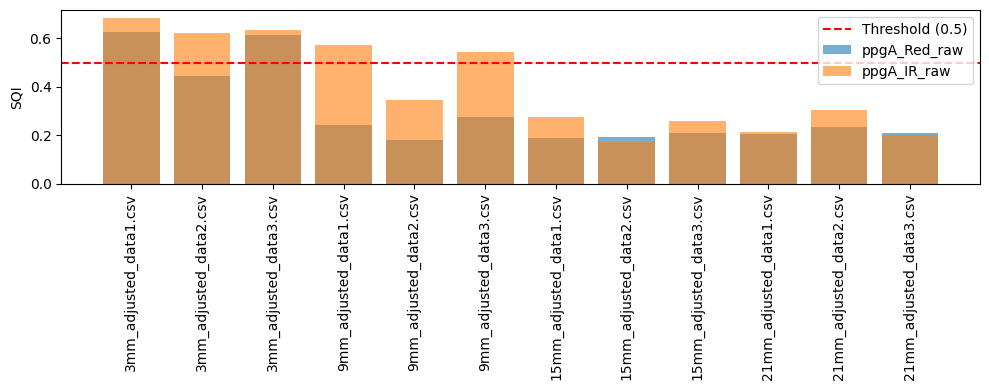

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import correlate

# ===== 設定 =====
fs = 2000  # サンプリング周波数 [Hz]
files = [f"{d}mm_adjusted_data{i}.csv" for d in [3,9,15,21] for i in [1,2,3]]  # データファイル一覧

def calc_sqi(signal, fs=2000):
    """1ch信号の簡易Signal Quality Indexを計算"""
    # --- AC/DC ---
    amp = np.nanmax(signal) - np.nanmin(signal)
    mean_val = np.nanmean(signal)
    acdc = amp / (np.abs(mean_val) + 1e-8)

    # --- 自己相関 ---
    # 0.5〜1.5Hz程度（30-90 bpm）を目安に1拍相当の遅延での相関を計算
    sec_per_beat = 60 / 65  # 平均心拍65bpm程度の仮定
    lag = int(fs * sec_per_beat)
    if lag < len(signal):
        corr = correlate(signal - np.nanmean(signal), signal - np.nanmean(signal), mode='full')
        corr = corr[corr.size // 2:]
        corr = corr / np.max(corr)  # 最大1に正規化
        autocorr_beat = corr[lag] if lag < len(corr) else 0
    else:
        autocorr_beat = np.nan

    # --- スペクトル特徴 ---
    f, Pxx = welch(signal, fs=fs, nperseg=fs*2)
    Pxx = np.nan_to_num(Pxx)
    dom_idx = np.argmax(Pxx)
    dom_freq = f[dom_idx]
    dom_power = Pxx[dom_idx]
    total_power = np.sum(Pxx)
    dom_ratio = dom_power / (total_power + 1e-8)

    # 高周波ノイズ比（>10Hzのパワー比）
    high_freq_power = np.sum(Pxx[f > 10])
    noise_ratio = high_freq_power / (total_power + 1e-8)

    # --- SQI計算（例: 振幅, 自己相関, 主周波数優位, ノイズ低さ） ---
    # それぞれ0〜1程度にスケールして合算（簡易）
    # 実運用では特徴の重み付けや閾値設定は要調整
    amp_score = np.clip(acdc / 2.0, 0, 1)        # AC/DCが2以上で満点
    autocorr_score = np.clip(autocorr_beat, 0, 1)
    dom_score = np.clip(dom_ratio / 0.5, 0, 1)   # 主周波数50%以上で満点
    noise_score = 1 - np.clip(noise_ratio / 0.5, 0, 1)  # 高周波比50%以下で満点

    sqi = np.nanmean([amp_score, autocorr_score, dom_score, noise_score])
    return {
        "AC_DC": acdc,
        "Autocorr": autocorr_beat,
        "DomFreq_Hz": dom_freq,
        "DomRatio": dom_ratio,
        "NoiseRatio": noise_ratio,
        "SQI": sqi
    }

results = []

for file in files:
    df = pd.read_csv(file)
    for ch in ["ppgA_Red_raw", "ppgA_IR_raw"]:
        sig = df[ch].dropna().values
        sqi_metrics = calc_sqi(sig, fs=fs)
        results.append({
            "File": file,
            "Channel": ch,
            **sqi_metrics
        })

df_sqi = pd.DataFrame(results)
print(df_sqi.round(3))

# SQI判定（例: SQI > 0.5を合格ラインとする）
df_sqi["QualityFlag"] = df_sqi["SQI"] > 0.5
print("\n=== Signal Quality Assessment ===")
print(df_sqi[["File","Channel","SQI","QualityFlag"]].round(3))

# SQIを棒グラフで可視化
plt.figure(figsize=(10,4))
for ch in ["ppgA_Red_raw","ppgA_IR_raw"]:
    subset = df_sqi[df_sqi.Channel==ch]
    plt.bar(subset["File"], subset["SQI"], label=ch, alpha=0.6)
plt.axhline(0.5, color="red", linestyle="--", label="Threshold (0.5)")
plt.xticks(rotation=90)
plt.ylabel("SQI")
plt.legend()
plt.tight_layout()
plt.show()



=== Signal Quality Assessment ===
              Label Channel    SQI  QualityFlag
0        3mm_Normal     Red  0.624         True
1        3mm_Normal      IR  0.683         True
2     3mm_Ischaemia     Red  0.445        False
3     3mm_Ischaemia      IR  0.621         True
4    3mm_Congestion     Red  0.616         True
5    3mm_Congestion      IR  0.635         True
6        9mm_Normal     Red  0.241        False
7        9mm_Normal      IR  0.573         True
8     9mm_Ischaemia     Red  0.179        False
9     9mm_Ischaemia      IR  0.344        False
10   9mm_Congestion     Red  0.276        False
11   9mm_Congestion      IR  0.546         True
12      15mm_Normal     Red  0.189        False
13      15mm_Normal      IR  0.273        False
14   15mm_Ischaemia     Red  0.194        False
15   15mm_Ischaemia      IR  0.171        False
16  15mm_Congestion     Red  0.211        False
17  15mm_Congestion      IR  0.258        False
18      21mm_Normal     Red  0.204        False
19   

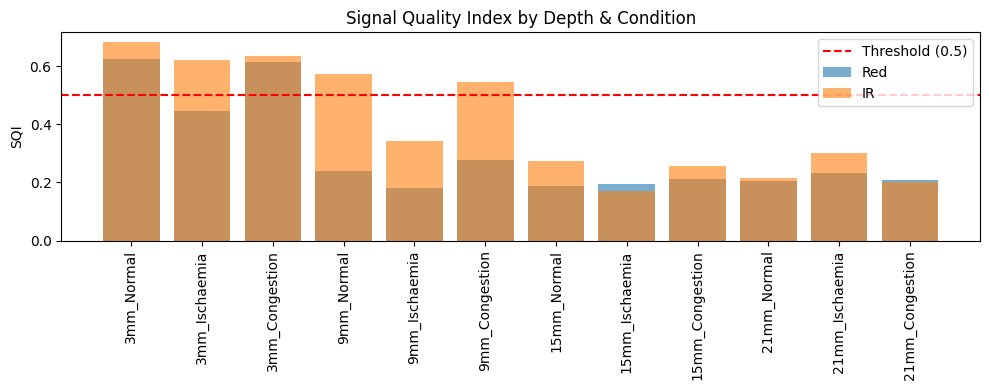

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, correlate

# ===== 設定 =====
fs = 2000  # サンプリング周波数 [Hz]
files = [f"{d}mm_AGC_data{i}.csv" for d in [3,9,15,21] for i in [1,2,3]]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}

def calc_sqi(signal, fs=2000):
    """Signal Quality Index (SQI) を簡易計算"""
    amp = np.nanmax(signal) - np.nanmin(signal)
    mean_val = np.nanmean(signal)
    acdc = amp / (np.abs(mean_val) + 1e-8)

    # 自己相関 (1拍遅れ)
    sec_per_beat = 60 / 65  # 65 bpm くらいを仮定
    lag = int(fs * sec_per_beat)
    if lag < len(signal):
        corr = correlate(signal - np.nanmean(signal), signal - np.nanmean(signal), mode='full')
        corr = corr[corr.size // 2:]
        corr = corr / np.max(corr)
        autocorr_beat = corr[lag] if lag < len(corr) else 0
    else:
        autocorr_beat = np.nan

    # Welch スペクトル
    f, Pxx = welch(signal, fs=fs, nperseg=fs*2)
    Pxx = np.nan_to_num(Pxx)
    dom_idx = np.argmax(Pxx)
    dom_power = Pxx[dom_idx]
    total_power = np.sum(Pxx)
    dom_ratio = dom_power / (total_power + 1e-8)
    high_freq_power = np.sum(Pxx[f > 10])
    noise_ratio = high_freq_power / (total_power + 1e-8)

    # スコア化
    amp_score = np.clip(acdc / 2.0, 0, 1)
    autocorr_score = np.clip(autocorr_beat, 0, 1)
    dom_score = np.clip(dom_ratio / 0.5, 0, 1)
    noise_score = 1 - np.clip(noise_ratio / 0.5, 0, 1)
    sqi = np.nanmean([amp_score, autocorr_score, dom_score, noise_score])
    return {
        "AC_DC": acdc,
        "Autocorr": autocorr_beat,
        "DomRatio": dom_ratio,
        "NoiseRatio": noise_ratio,
        "SQI": sqi
    }

results = []

for file in files:
    df = pd.read_csv(file)
    # ファイル名を Depth_Condition に変換
    fname = file.split("/")[-1]
    fname = fname.replace("AGC_", "")
    # 例: "3mm_data1.csv" -> depth=3, state="Normal"
    depth = fname.split("mm")[0]
    state_key = fname.split("_")[1].replace(".csv","")
    state_label = state_map.get(state_key, state_key)
    label_name = f"{depth}mm_{state_label}"

    for ch in ["ppgA_Red_raw", "ppgA_IR_raw"]:
        sig = df[ch].dropna().values
        sqi_metrics = calc_sqi(sig, fs=fs)
        results.append({
            "Label": label_name,
            "Channel": "Red" if "Red" in ch else "IR",
            **sqi_metrics
        })

df_sqi = pd.DataFrame(results)

# SQI判定（例: SQI > 0.5を合格ラインとする）
df_sqi["QualityFlag"] = df_sqi["SQI"] > 0.5
print("\n=== Signal Quality Assessment ===")
print(df_sqi[["Label","Channel","SQI","QualityFlag"]].round(3))

# ===== 可視化 =====
plt.figure(figsize=(10,4))
for ch in ["Red","IR"]:
    subset = df_sqi[df_sqi.Channel==ch]
    plt.bar(subset["Label"], subset["SQI"], label=ch, alpha=0.6)

plt.axhline(0.5, color="red", linestyle="--", label="Threshold (0.5)")
plt.xticks(rotation=90)
plt.ylabel("SQI")
plt.title("Signal Quality Index by Depth & Condition")
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import savgol_filter, correlate
from scipy.fft import rfft, rfftfreq

# ===== パラメータ =====
fs = 2000              # サンプリング周波数 [Hz]
target_amp = 1.0       # AGC後の目標振幅
window_sec = 8         # SQI評価窓の長さ [秒]
gain_limit = (0.1, 10) # AGCゲインの制限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ======== AGC 関数 ========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg) == 0:
            continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ======== SQI 関数 ========
def compute_sqi(segment, fs):
    if len(segment) < fs:
        return np.nan
    # --- 1. 振幅対雑音比 ---
    amp = segment.max() - segment.min()
    noise = np.std(segment)
    snr = amp / (noise + 1e-8)
    snr_norm = min(snr/10, 1)

    # --- 2. 自己相関 (周期性) ---
    corr = correlate(segment - np.mean(segment), segment - np.mean(segment), mode='full')
    corr = corr[len(corr)//2:]
    corr = corr / (np.max(corr)+1e-8)
    lag_min = int(0.5*fs)
    lag_max = int(1.5*fs)
    if lag_max >= len(corr):
        lag_max = len(corr)-1
    ac_peak = np.max(corr[lag_min:lag_max]) if lag_max>lag_min else 0
    ac_norm = np.clip(ac_peak, 0, 1)

    # --- 3. 周波数ドミナンス ---
    freqs = rfftfreq(len(segment), 1/fs)
    fft_vals = np.abs(rfft(segment))
    mask = (freqs>0.5) & (freqs<3)
    if not np.any(mask):
        return np.nan
    band_power = fft_vals[mask]
    peak = np.max(band_power)
    total = np.sum(band_power)
    dom = peak / (total+1e-8)
    dom_norm = np.clip(dom*5, 0, 1)

    # 総合SQI
    return np.mean([snr_norm, ac_norm, dom_norm])

# ===== SQI計算 =====
records = []

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv")
        if not file.exists():
            print(f"[警告] {file} が存在しません")
            continue

        df = pd.read_csv(file)

        for ch in ["ppgA_Red_AGC", "ppgA_IR_AGC"]:
            sig = savgol_filter(df[ch].values, 51, 3)

            # window_sec ごとに SQI 計算
            step = int(window_sec * fs)
            sqis = []
            for start in range(0, len(sig)-step, step):
                seg = sig[start:start+step]
                sqi_val = compute_sqi(seg, fs)
                sqis.append(sqi_val)

            mean_sqi = np.nanmean(sqis)
            std_sqi = np.nanstd(sqis)
            valid_ratio = np.mean(~np.isnan(sqis))

            records.append({
                "Depth": depth,
                "Condition": state_name,
                "Channel": "Red" if "Red" in ch else "IR",
                "SQI_mean": mean_sqi,
                "SQI_std": std_sqi,
                "Valid_ratio": valid_ratio,
                "n_windows": len(sqis)
            })

# ===== 結果を保存 =====
df_sqi = pd.DataFrame(records)
df_sqi.to_csv("SQI_summary.csv", index=False)
print("✅ SQI_summary.csv を出力しました")
print(df_sqi.round(3))

✅ SQI_summary.csv を出力しました
    Depth   Condition Channel  SQI_mean  SQI_std  Valid_ratio  n_windows
0       3      Normal     Red     0.751    0.001          1.0          3
1       3      Normal      IR     0.735    0.002          1.0          3
2       3   Ischaemia     Red     0.752    0.002          1.0          3
3       3   Ischaemia      IR     0.736    0.001          1.0          3
4       3  Congestion     Red     0.749    0.003          1.0          3
5       3  Congestion      IR     0.738    0.000          1.0          3
6       9      Normal     Red     0.639    0.016          1.0          3
7       9      Normal      IR     0.743    0.000          1.0          3
8       9   Ischaemia     Red     0.666    0.023          1.0          3
9       9   Ischaemia      IR     0.748    0.002          1.0          3
10      9  Congestion     Red     0.701    0.030          1.0          3
11      9  Congestion      IR     0.741    0.001          1.0          3
12     15      Normal    

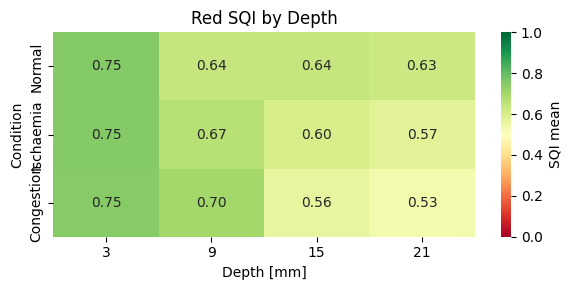

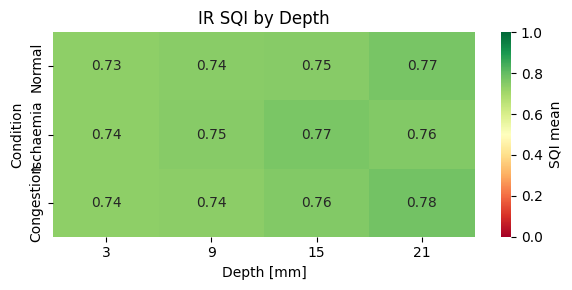

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== SQI 集計結果の読み込み =====
df_sqi = pd.read_csv("SQI_summary.csv")

# ===== Red と IR に分ける =====
df_red = df_sqi[df_sqi["Channel"] == "Red"]
df_ir  = df_sqi[df_sqi["Channel"] == "IR"]

# ===== Pivotしてヒートマップ用の表を作成 =====
red_pivot = df_red.pivot(index="Condition", columns="Depth", values="SQI_mean")
ir_pivot  = df_ir.pivot(index="Condition", columns="Depth", values="SQI_mean")

# Condition の表示順を統一
order = ["Normal", "Ischaemia", "Congestion"]
red_pivot = red_pivot.reindex(order)
ir_pivot  = ir_pivot.reindex(order)

# ===== ヒートマップ描画 =====
def plot_sqi_heatmap(data, title):
    plt.figure(figsize=(6,3))
    sns.heatmap(
        data,
        annot=True, fmt=".2f",
        cmap="RdYlGn", center=0.5,  # 0.5 を基準色に
        vmin=0, vmax=1,             # SQI の範囲を 0〜1 に固定
        cbar_kws={"label": "SQI mean"}
    )
    plt.title(title)
    plt.xlabel("Depth [mm]")
    plt.ylabel("Condition")
    plt.tight_layout()
    plt.show()

plot_sqi_heatmap(red_pivot, "Red SQI by Depth")
plot_sqi_heatmap(ir_pivot,  "IR SQI by Depth")


In [80]:
import pandas as pd
import numpy as np
from pathlib import Path

# ========= パラメータ =========
fs = 2000             # サンプリング周波数
target_amp = 1.0      # AGC後の目標振幅
gain_limit = (0.1,10) # AGCゲインの上下限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ========= AGC 関数 =========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    """一定区間ごとにAGCをかけて振幅をそろえる"""
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg)==0: continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ========= 全ファイル処理 =========
for depth in depths:
    for i_state, state_name in state_map.items():
        input_file = f"{depth}mm_adjusted_data{i_state}.csv"
        output_file = f"{depth}mm_AGC_data{i_state}.csv"
        
        # ファイル読み込み
        df = pd.read_csv(input_file)
        if not {"ppgA_Red_raw","ppgA_IR_raw"}.issubset(df.columns):
            print(f"[警告] {input_file} に必要な列がありません")
            continue

        # AGC適用
        df["ppgA_Red_AGC"] = apply_agc(df["ppgA_Red_raw"].values, fs, 1, target_amp, gain_limit)
        df["ppgA_IR_AGC"]  = apply_agc(df["ppgA_IR_raw"].values,  fs, 1, target_amp, gain_limit)

        # 保存
        df.to_csv(output_file, index=False)
        print(f"[保存完了] {output_file}")


[保存完了] 3mm_AGC_data1.csv
[保存完了] 3mm_AGC_data2.csv
[保存完了] 3mm_AGC_data2.csv
[保存完了] 3mm_AGC_data3.csv
[保存完了] 3mm_AGC_data3.csv
[保存完了] 9mm_AGC_data1.csv
[保存完了] 9mm_AGC_data1.csv
[保存完了] 9mm_AGC_data2.csv
[保存完了] 9mm_AGC_data2.csv
[保存完了] 9mm_AGC_data3.csv
[保存完了] 9mm_AGC_data3.csv
[保存完了] 15mm_AGC_data1.csv
[保存完了] 15mm_AGC_data1.csv
[保存完了] 15mm_AGC_data2.csv
[保存完了] 15mm_AGC_data2.csv
[保存完了] 15mm_AGC_data3.csv
[保存完了] 15mm_AGC_data3.csv
[保存完了] 21mm_AGC_data1.csv
[保存完了] 21mm_AGC_data1.csv
[保存完了] 21mm_AGC_data2.csv
[保存完了] 21mm_AGC_data2.csv
[保存完了] 21mm_AGC_data3.csv
[保存完了] 21mm_AGC_data3.csv


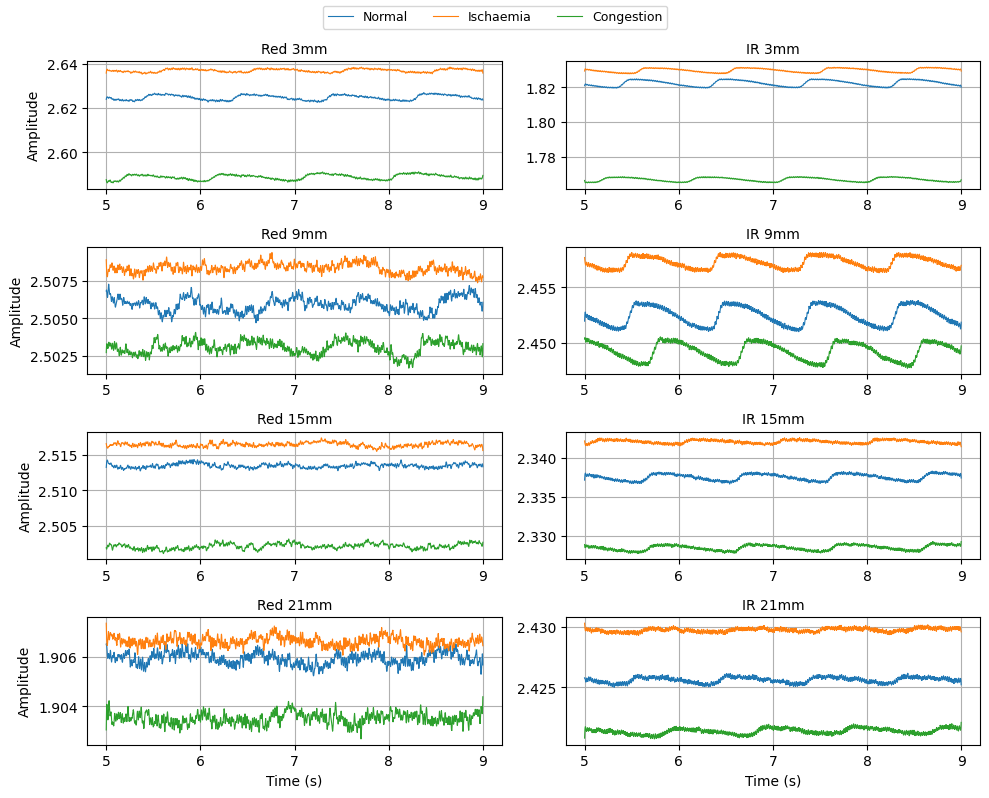

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.ticker as ticker

# ===== パラメータ設定 =====
fs = 2000                # サンプリング周波数
start_time = 5           # 秒
display_time = 4         # 秒
legend_labels = ['Normal', 'Ischaemia', 'Congestion']
depths = [3, 9, 15, 21]
channels = {"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"}

# ===== プロット準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), sharex=False, sharey=False)
# axes は4x2の2次元配列になる

for row, depth in enumerate(depths):
    for col, (ch_name, ch_col) in enumerate(channels.items()):
        ax = axes[row, col]
        for i, state_idx in enumerate([1, 2, 3]):  # Normal, Ischaemia, Congestion
            file = f"{depth}mm_AGC_data{state_idx}.csv"
            data = pd.read_csv(file)

            start_index = int(start_time * fs)
            end_index = start_index + int(display_time * fs)
            time = np.arange(start_index, end_index) / fs
            signal = data[ch_col].values[start_index:end_index]

            # Savitzky–Golay フィルタで平滑化
            smoothed = savgol_filter(signal, window_length=51, polyorder=3)
            ax.plot(time, smoothed, label=legend_labels[i], linewidth=0.8)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.set_title(f"{ch_name} {depth}mm", fontsize=10)
        if col == 0:
            ax.set_ylabel('Amplitude')
        if row == len(depths) - 1:
            ax.set_xlabel('Time (s)')
        ax.grid(True)

# ===== 凡例をまとめて一度だけ表示 =====
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Red 3mm Normal mean = 2.625
IR 3mm Normal mean = 1.822


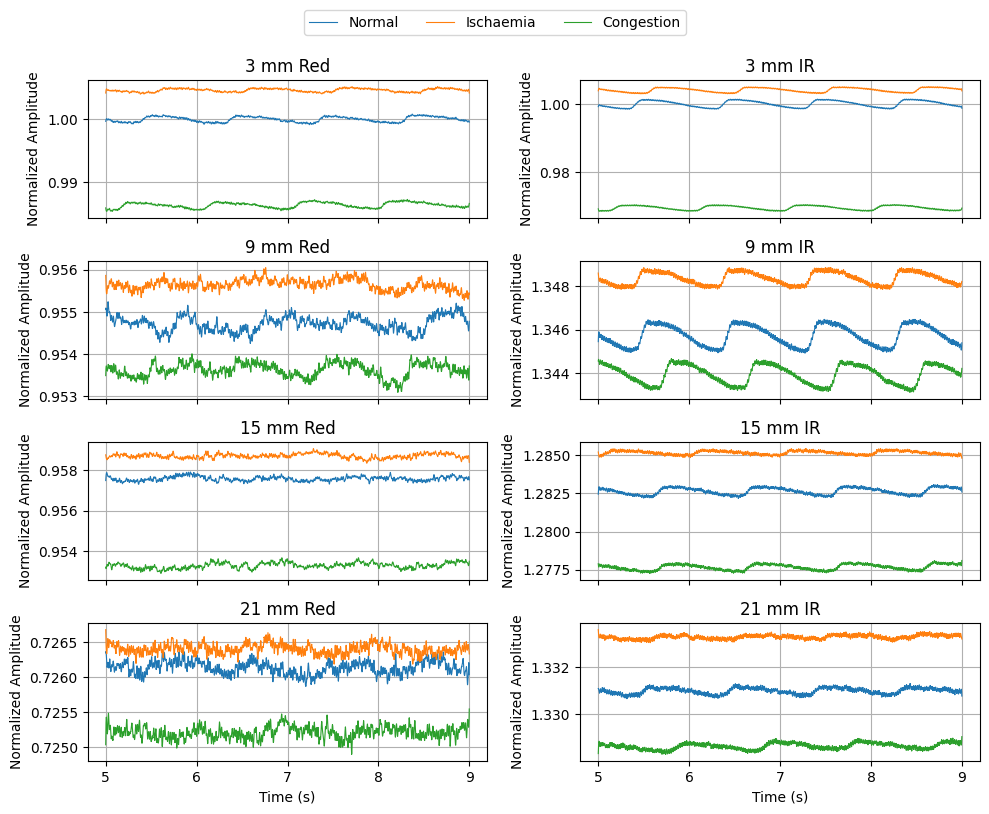

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.ticker as ticker

# ===== 基本設定 =====
fs = 2000          # サンプリングレート [Hz]
start_time = 5     # 表示開始秒
display_time = 4   # 表示する時間幅 [秒]
depths = [3, 9, 15, 21]
legend_labels = ['Normal', 'Ischaemia', 'Congestion']

# ファイル名の対応 (data1=Normal, data2=Ischaemia, data3=Congestion)
state_files = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ===== 正規化用の基準（3mm Normal の平均DC）を計算 =====
norm_base_mean = {}
for ch_name, ch_col in {"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"}.items():
    df0 = pd.read_csv("3mm_AGC_data1.csv")  # 3mm Normal
    s = int(start_time * fs)
    e = s + int(display_time * fs)
    seg0 = df0[ch_col].values[s:e]
    norm_base_mean[ch_name] = seg0.mean()
    print(f"{ch_name} 3mm Normal mean = {norm_base_mean[ch_name]:.3f}")

# ===== Figureを作成 (4行×2列) =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), sharex=True)

for row_idx, depth in enumerate(depths):
    for col_idx, (ch_name, ch_col) in enumerate({"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"}.items()):
        ax = axes[row_idx, col_idx]
        for i_state, state_name in state_files.items():
            file = f"{depth}mm_AGC_data{i_state}.csv"
            df = pd.read_csv(file)
            s = int(start_time * fs)
            e = s + int(display_time * fs)
            time = np.arange(s, e) / fs
            signal = df[ch_col].values[s:e]

            # ===== DC基準で正規化（3mm Normal の平均DCで割る）=====
            base = norm_base_mean[ch_name]
            signal_norm = signal / (base + 1e-9)

            # 平滑化
            smoothed = savgol_filter(signal_norm, window_length=51, polyorder=3)

            ax.plot(time, smoothed, label=state_name, linewidth=0.8)

        # 軸設定
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.set_ylabel("Normalized Amplitude")
        if row_idx == 0:
            ax.set_title(f"{ch_name} signal")
        if row_idx == len(depths) - 1:
            ax.set_xlabel("Time (s)")
        ax.set_title(f"{depth} mm {ch_name}")
        ax.grid(True)

# 凡例（共通でまとめる）
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



Normalization baseline (mean): {'Red': np.float64(2.624772852200389), 'IR': np.float64(1.8223978190702328)}


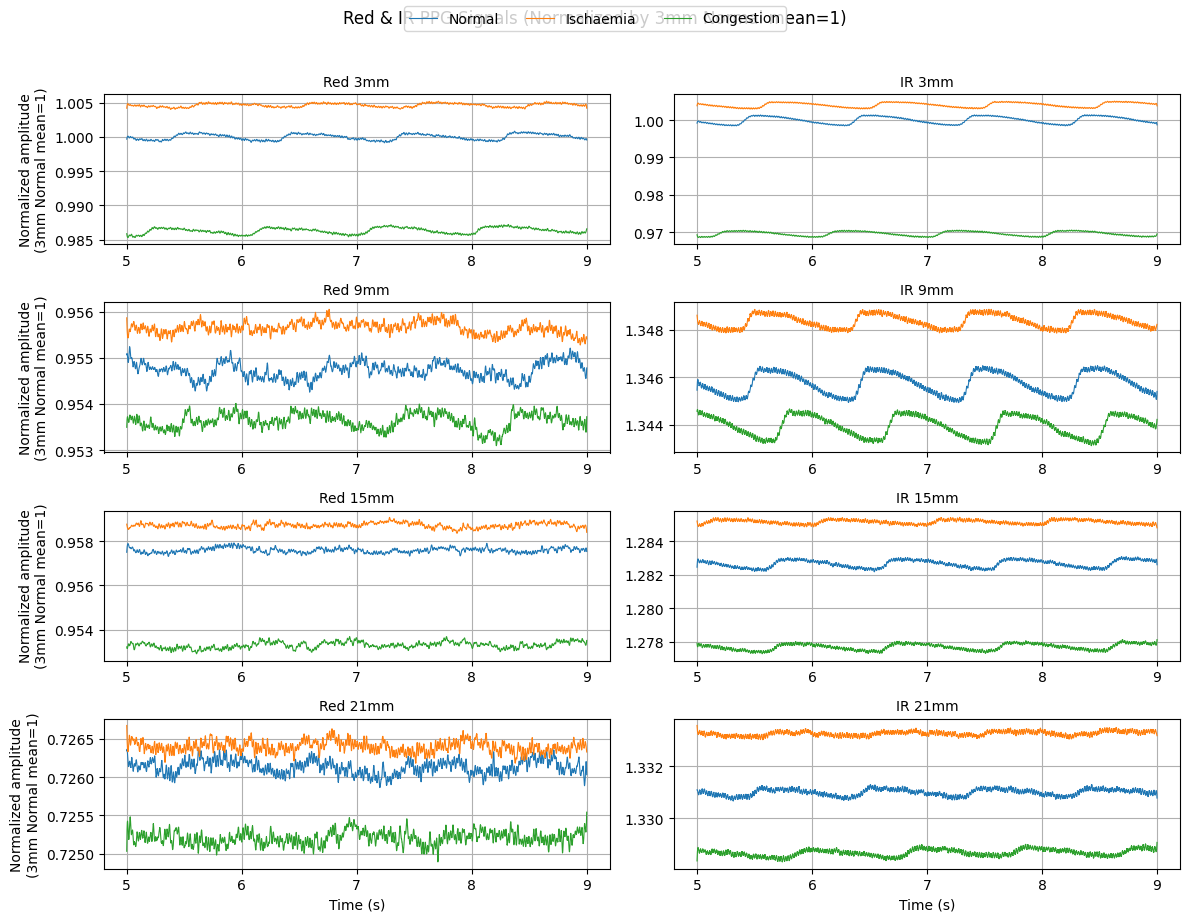

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.ticker as ticker

# ========= パラメータ設定 =========
fs = 2000  # サンプリングレート [Hz]
start_time = 5      # 表示開始時間 [秒]
display_time = 4    # 表示時間 [秒]

depths = [3, 9, 15, 21]
states = ["Normal", "Ischaemia", "Congestion"]
legend_labels = ['Normal', 'Ischaemia', 'Congestion']
channels = {"Red": "ppgA_Red_raw", "IR": "ppgA_IR_raw"}

# ========= 3mm Normal の平均値を基準にする =========
norm_base_mean = {}
for ch_name, ch_col in channels.items():
    file = f"3mm_AGC_data1.csv"  # data1 = Normal
    df0 = pd.read_csv(file)
    s = int(start_time * fs)
    e = s + int(display_time * fs)
    seg0 = df0[ch_col].values[s:e]
    norm_base_mean[ch_name] = seg0.mean()

print("Normalization baseline (mean):", norm_base_mean)

# ========= Figure設定 (4行×2列: 各深さ×Red/IR) =========
fig, axes = plt.subplots(len(depths), len(channels), figsize=(12, 9), sharex=False)

for row, depth in enumerate(depths):
    for col, (ch_name, ch_col) in enumerate(channels.items()):
        ax = axes[row, col]

        for i, state in enumerate(states, start=1):
            file = f"{depth}mm_AGC_data{i}.csv"  # data1,2,3 = Normal,Ischaemia,Congestion
            df = pd.read_csv(file)

            start_index = int(start_time * fs)
            end_index = start_index + int(display_time * fs)
            time = np.arange(start_index, end_index) / fs
            signal = df[ch_col].values[start_index:end_index]

            # ★ 3mm Normal の平均値で正規化 ★
            base = norm_base_mean[ch_name]
            signal_norm = signal / (base + 1e-9)

            # 平滑化
            smoothed = savgol_filter(signal_norm, window_length=51, polyorder=3)

            # プロット
            ax.plot(time, smoothed, label=legend_labels[i-1], linewidth=0.8)

        # 軸ラベルとタイトル
        ax.set_title(f"{ch_name} {depth}mm", fontsize=10)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.grid(True)

        if col == 0:
            ax.set_ylabel('Normalized amplitude\n(3mm Normal mean=1)')
        if row == len(depths)-1:
            ax.set_xlabel('Time (s)')

# 凡例をまとめて1つ表示
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10)

fig.suptitle("Red & IR PPG Signals (Normalized by 3mm Normal mean=1)", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()



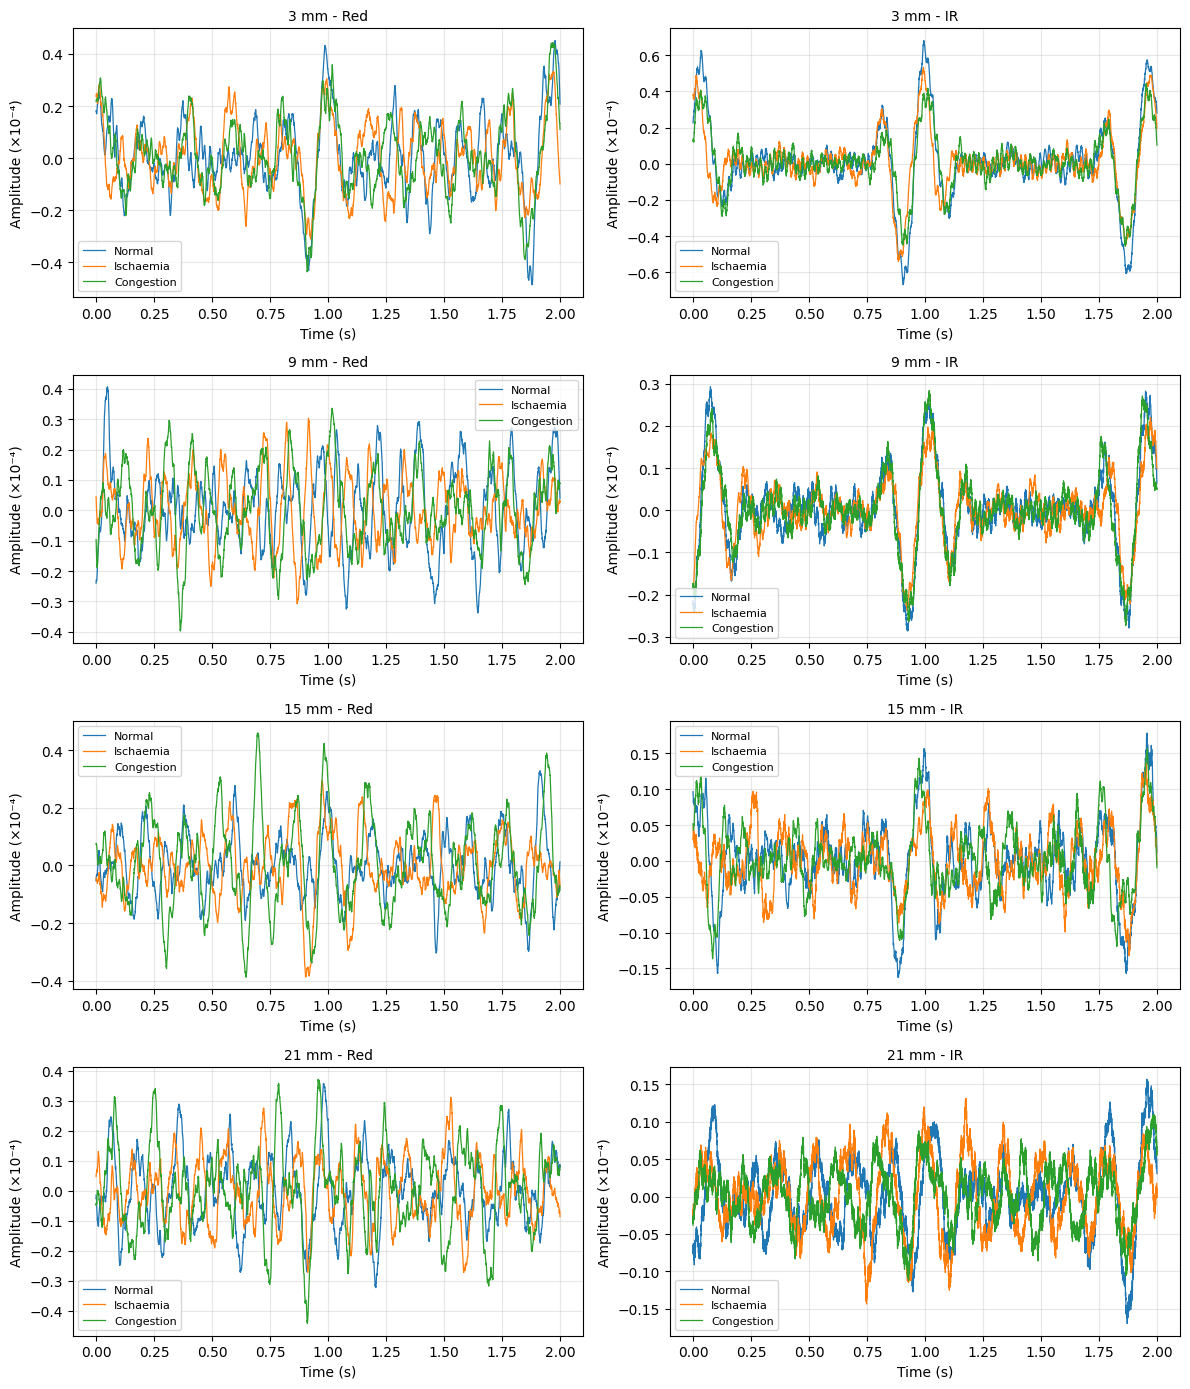

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.lib.stride_tricks import sliding_window_view

# ===== パラメータ =====
fs = 2000                 # サンプリング周波数 [Hz]
view_sec = 3.0            # 表示区間長 [s]
search_start_sec = 7.0    # 探索開始 [s]
smooth_window = 2001      # 強スムージング窓（奇数）
polyorder = 2
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

def ac_dc_normalize(sig, smooth_win, poly=2):
    if len(sig) <= 5: return np.zeros_like(sig)
    win = smooth_win if len(sig) > smooth_win else (len(sig)//2)*2+1
    dc = savgol_filter(sig, win, poly)
    return (sig - dc) / (dc + 1e-8)

def strong_smooth(sig, smooth_win=1001, poly=3):
    if len(sig) <= 5: return sig
    win = smooth_win if len(sig) > smooth_win else (len(sig)//2)*2+1
    return savgol_filter(sig, win, poly)

def zscore(x):
    m, s = np.nanmean(x), np.nanstd(x)
    s = s if s>1e-12 else 1e-12
    return (x - m)/s

def find_best_start_by_template(sig_z, templ_z, fs, search_start_sec, view_sec, min_corr=0.20):
    L = len(templ_z)
    if len(sig_z) < L: return None, None
    start0 = int(search_start_sec * fs)
    if start0 > len(sig_z) - L: start0 = max(0, len(sig_z)-L)
    windows = sliding_window_view(sig_z[start0:], L)
    corrs = (windows @ templ_z)/L
    valid_len = min(len(corrs), len(sig_z)-L - start0 +1)
    if valid_len<=0: return None, None
    corrs = corrs[:valid_len]
    best_rel = int(np.argmax(corrs))
    best_corr = float(corrs[best_rel])
    best_start = start0+best_rel
    if best_start+L>len(sig_z): return None, None
    if best_corr<min_corr: return None, best_corr
    return best_start,best_corr

def fallback_min_start(smoothed, fs, search_start_sec, view_sec):
    start_idx=int(search_start_sec*fs)
    if start_idx>=len(smoothed): start_idx=0
    min_idx=np.argmin(smoothed[start_idx:])+start_idx
    k=int(view_sec*fs)
    if min_idx+k>len(smoothed): min_idx=max(0,len(smoothed)-k)
    return min_idx

# ---- 参照テンプレート ----
templ_file="3mm_adjusted_data1.csv"
df_t=pd.read_csv(templ_file)
sig_t= df_t["ppgA_IR_raw"].dropna().values
sig_t_acdc= ac_dc_normalize(sig_t,smooth_window,poly=2)
sig_t_s= strong_smooth(sig_t_acdc,smooth_window,polyorder)
templ_start= fallback_min_start(sig_t_s,fs,search_start_sec,view_sec)
templ_k= int(view_sec*fs)
templ_seg= sig_t_s[templ_start:templ_start+templ_k]
templ_z= zscore(templ_seg)

# ===== 図 =====
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(12,14))
axes=axes.reshape(4,2)

for i_depth,depth in enumerate(depths):
    for j_ch,(col,ch_label) in enumerate(channels.items()):
        ax=axes[i_depth,j_ch]
        for skey,sname in state_map.items():
            file=f"{depth}mm_adjusted_{skey}.csv"
            try:
                df=pd.read_csv(file)
            except: continue
            if col not in df.columns: continue
            sig=df[col].dropna().values
            if len(sig)<int((search_start_sec+view_sec)*fs): continue

            sig_acdc=ac_dc_normalize(sig,smooth_window,poly=2)
            sig_s=strong_smooth(sig_acdc,smooth_window,polyorder)
            sig_z=zscore(sig_s)

            best_start,_=find_best_start_by_template(sig_z,templ_z,fs,search_start_sec,view_sec)
            if best_start is None:
                best_start=fallback_min_start(sig_s,fs,search_start_sec,view_sec)

            seg= sig_s[best_start:best_start+templ_k]

            # ---- ★ここで最初2/3だけ表示 ----
            cut_len=int(len(seg)*2/3)
            seg=seg[:cut_len]
            t=np.arange(cut_len)/fs

            ax.plot(t, seg*1e4, label=sname, lw=0.9)

        ax.set_title(f"{depth} mm - {ch_label}",fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (×10⁻⁴)")
        ax.grid(True,alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()




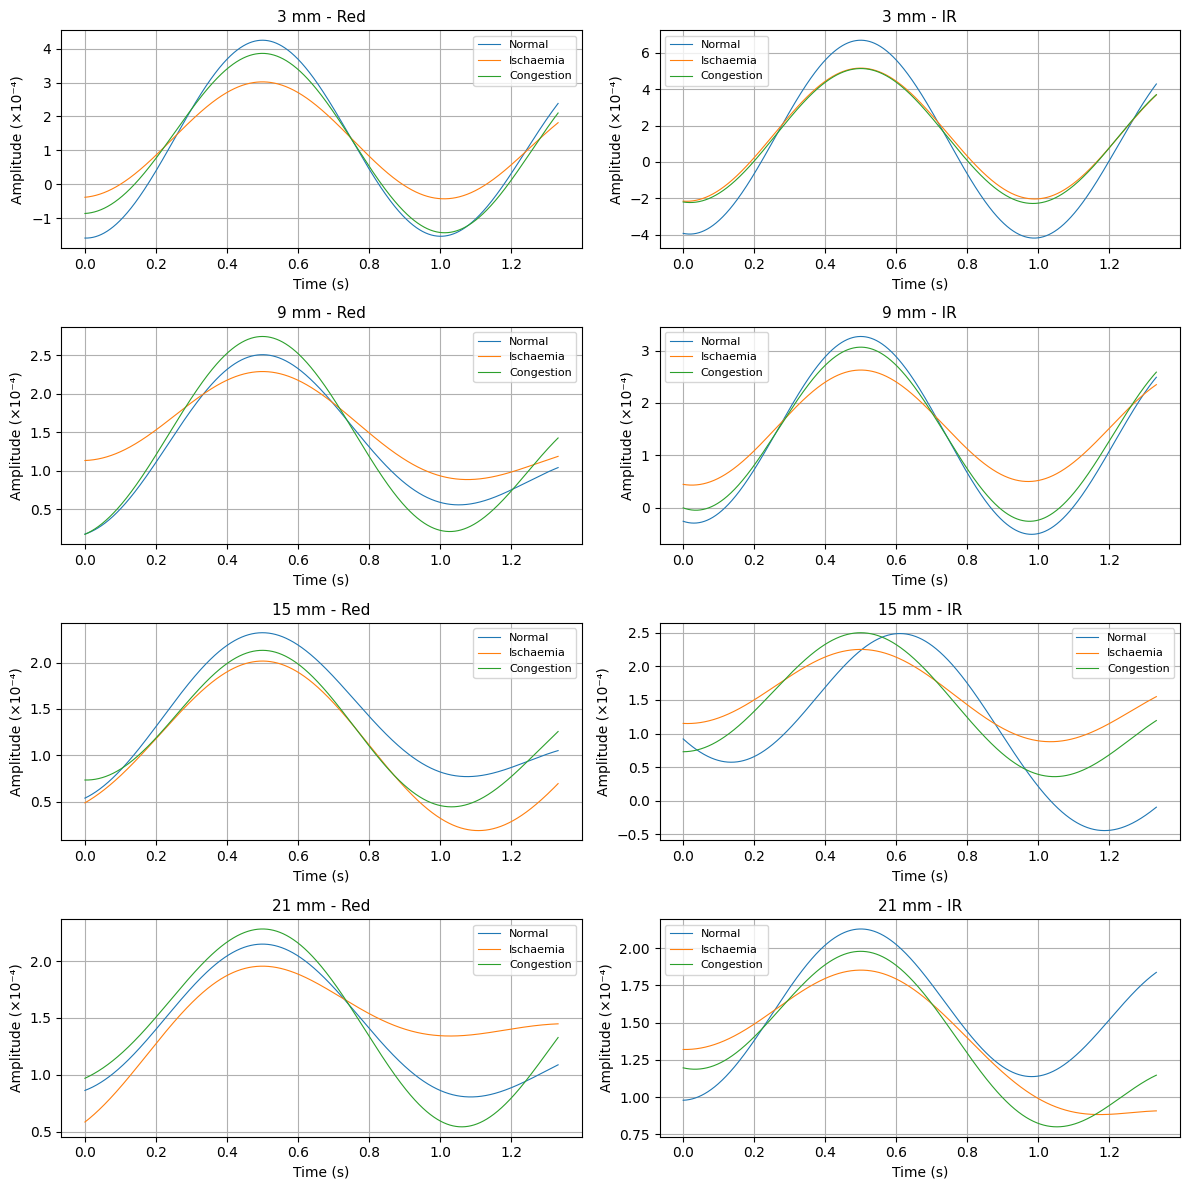

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 表示時間 [秒]
start_search = 3      # 検索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=1.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ch_label) in enumerate(channels.items()):
        ax = axes[i_depth, j_ch]

        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # --- AC/DC正規化 ---
            dc = butter_lowpass_filter(sig, fs, cutoff=0.5)
            sig_norm = (sig - dc) / (dc + 1e-8)

            # --- 強スムージング ---
            smoothed = butter_lowpass_filter(sig_norm, fs, cutoff=1.0)

            # --- 開始5秒以降の最大値（ピーク）を検出 ---
            start_idx = int(start_search * fs)
            if start_idx >= len(smoothed):
                start_idx = 0
            max_idx = np.argmax(smoothed[start_idx:]) + start_idx

            # --- 表示区間（ピーク中心 → 前にずらす） ---
            view_len = int(view_sec * fs)
            pre_offset = int(view_len * 0.25)  # ピークから0.75秒前に開始
            start_plot = max(max_idx - pre_offset, 0)
            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            # --- 表示は先頭2/3まで ---
            cut_len = int(view_len * 2 / 3)
            seg = smoothed[start_plot:start_plot + cut_len]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg * 1e4, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ch_label}", fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (×10⁻⁴)")
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()



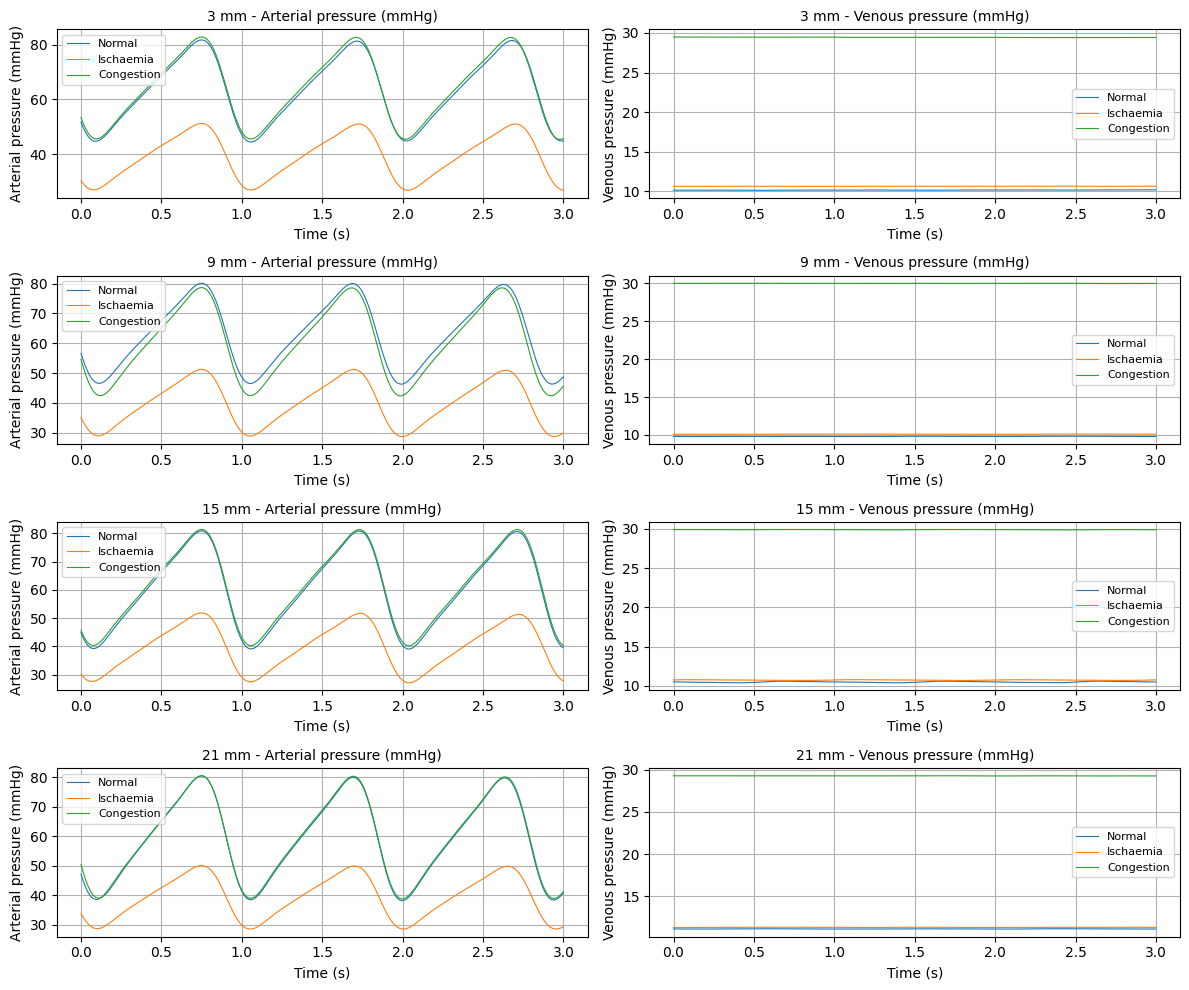

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 3          # 表示時間 [秒]
start_search = 5      # ピーク探索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
pressure_channels = {"p2_mmhg": "Arterial pressure (mmHg)", "p1_mmhg": "Venous pressure (mmHg)"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=3.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ylabel) in enumerate(pressure_channels.items()):
        ax = axes[i_depth, j_ch]
        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # スムージング
            smoothed = butter_lowpass_filter(sig, fs, cutoff=3.0)

            # 表示区間の決定
            view_len = int(view_sec * fs)
            start_idx = int(start_search * fs)

            if col_name == "p2_mmhg":  # 動脈 → ピーク揃え
                max_idx = np.argmax(smoothed[start_idx:]) + start_idx
                pre_offset = int(view_len * 0.25)
                start_plot = max(max_idx - pre_offset, 0)
            else:  # 静脈 → 一律スタート
                start_plot = start_idx

            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            seg = smoothed[start_plot:end_plot]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ylabel}", fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()



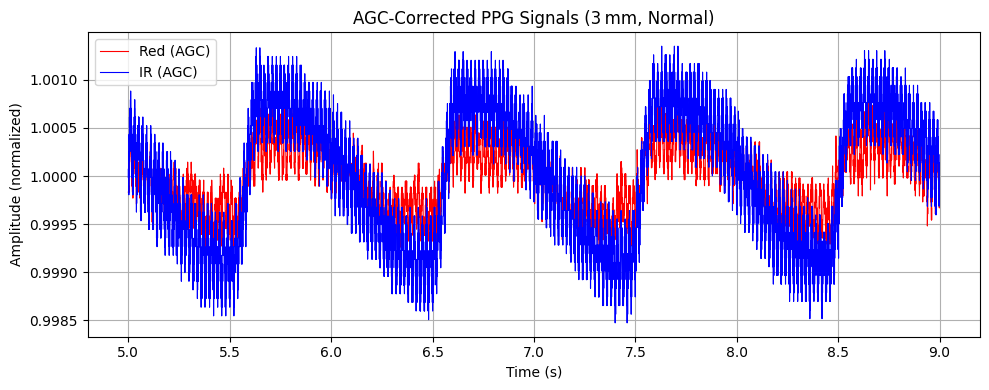

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== パラメータ =====
fs = 2000  # サンプリング周波数 [Hz]
start_time = 5     # 表示開始時間 [秒]
duration = 4       # 表示時間長さ [秒]

# ===== ファイル読み込み =====
file = "3mm_AGC_data2.csv"
df = pd.read_csv(file)

# ===== 信号の抽出 =====
red_agc = df["ppgA_Red_AGC"].dropna().values
ir_agc  = df["ppgA_IR_AGC"].dropna().values

# ===== 表示範囲の計算 =====
start_idx = int(start_time * fs)
end_idx = start_idx + int(duration * fs)

# 信号の長さチェック
if end_idx > len(red_agc) or end_idx > len(ir_agc):
    raise ValueError("指定された表示区間が信号長より長いです")

# 切り出し
t = np.arange(start_idx, end_idx) / fs
red_seg = red_agc[start_idx:end_idx]
ir_seg  = ir_agc[start_idx:end_idx]

# ===== プロット =====
plt.figure(figsize=(10, 4))
plt.plot(t, red_seg, label="Red (AGC)", color='red', linewidth=0.8)
plt.plot(t, ir_seg,  label="IR (AGC)",  color='blue', linewidth=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (normalized)")
plt.title("AGC-Corrected PPG Signals (3 mm, Normal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


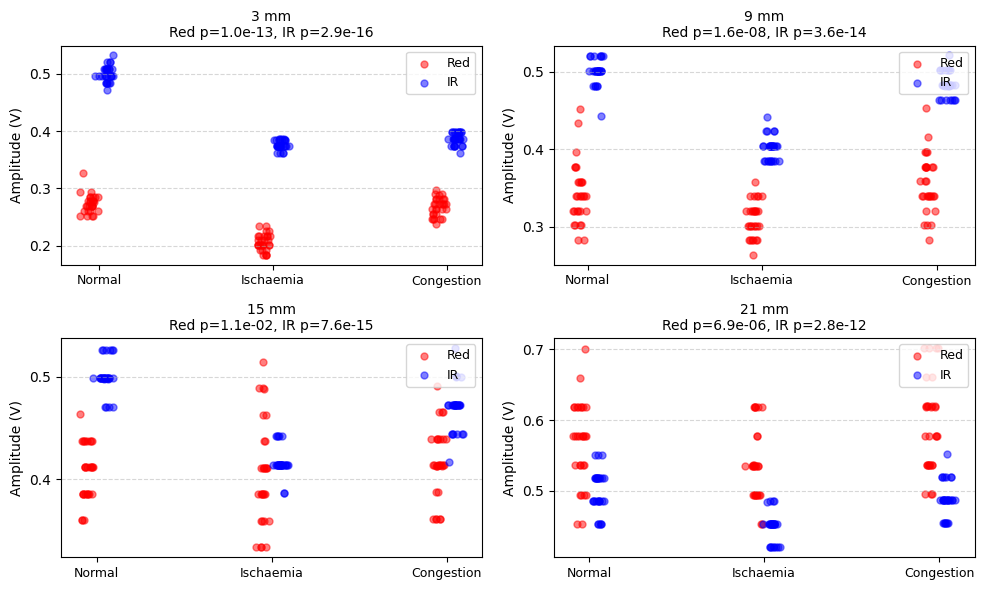

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import matplotlib.ticker as ticker

# ========= 設定 =========
fs = 2000        # サンプリングレート [Hz]
window_sec = 1   # 1拍分の近似 [秒]
depths = [3, 9, 15, 21]
state_map = {
    "data1": "Normal",
    "data2": "Ischaemia",
    "data3": "Congestion"
}

# ========= グラフ準備（2x2配置）=========
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

for idx, depth in enumerate(depths):
    red_groups = []
    ir_groups = []
    labels = []

    for state_key, label in state_map.items():
        file = f"{depth}mm_AGC_{state_key}.csv"
        try:
            df = pd.read_csv(file)
        except FileNotFoundError:
            print(f"⚠️ {file} が見つかりません")
            continue

        red = df["ppgA_Red_AGC"].values
        ir  = df["ppgA_IR_AGC"].values

        step = int(fs * window_sec)
        n_win = len(red) // step

        red_amp = []
        ir_amp  = []
        for w in range(n_win):
            s = w * step
            e = s + step
            rseg = red[s:e]
            iseg = ir[s:e]
            if len(rseg) < 2 or len(iseg) < 2:
                continue
            red_amp.append(rseg.max() - rseg.min())
            ir_amp.append(iseg.max() - iseg.min())

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)
        labels.append(label)

    # ========= Normal IR の平均を 0.5 にスケーリング =========
    if len(ir_groups) > 0:
        normal_ir_mean = np.mean(ir_groups[0])
        scale_factor = 0.5 / (normal_ir_mean + 1e-8)
    else:
        scale_factor = 1.0

    red_scaled = [[v * scale_factor for v in g] for g in red_groups]
    ir_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

    # ========= Kruskal-Wallis検定 =========
    try:
        stat_red, p_red = kruskal(*red_scaled)
    except:
        p_red = np.nan
    try:
        stat_ir, p_ir = kruskal(*ir_scaled)
    except:
        p_ir = np.nan

    # ========= 可視化 =========
    ax = axs[idx]
    for i, label in enumerate(labels):
        x_red = np.random.normal(i - 0.05, 0.02, len(red_scaled[i]))
        x_ir  = np.random.normal(i + 0.05, 0.02, len(ir_scaled[i]))
        ax.scatter(x_red, red_scaled[i], c="red", alpha=0.5, s=25, label="Red" if i == 0 else "")
        ax.scatter(x_ir,  ir_scaled[i],  c="blue", alpha=0.5, s=25, label="IR"  if i == 0 else "")

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylabel("Amplitude (V)", fontsize=10)
    ax.set_title(f"{depth} mm\nRed p={p_red:.1e}, IR p={p_ir:.1e}", fontsize=10)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)
    ax.legend(fontsize=9, loc="upper right")

plt.tight_layout()
plt.show()



In [144]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}

results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC_{data_key}.csv"
        try:
            df = pd.read_csv(file)
        except FileNotFoundError:
            print(f"⚠️ File not found: {file}")
            continue

        red = df["ppgA_Red_AGC"].dropna().values
        ir  = df["ppgA_IR_AGC"].dropna().values

        step = int(fs * window_sec)
        red_amp = [(red[i:i+step].max() - red[i:i+step].min())
                   for i in range(0, len(red) - step, step)]
        ir_amp = [(ir[i:i+step].max() - ir[i:i+step].min())
                  for i in range(0, len(ir) - step, step)]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ===== Kruskal-Wallis =====
    try:
        red_stat, red_p = kruskal(*red_groups)
        df_red = len(red_groups) - 1
    except Exception as e:
        red_stat, red_p, df_red = np.nan, np.nan, np.nan

    try:
        ir_stat, ir_p = kruskal(*ir_groups)
        df_ir = len(ir_groups) - 1
    except Exception as e:
        ir_stat, ir_p, df_ir = np.nan, np.nan, np.nan

    # ===== 出力保存用 =====
    results.append({
        "Depth": f"{depth}mm",
        "Channel": "Red",
        "Chi-Squared": red_stat,
        "df": df_red,
        "p-Value": red_p
    })
    results.append({
        "Depth": f"{depth}mm",
        "Channel": "IR",
        "Chi-Squared": ir_stat,
        "df": df_ir,
        "p-Value": ir_p
    })

    # ===== print表示 =====
    print(f"--- {depth}mm ---")
    print(f"Red: χ²={red_stat:.3f}, df={df_red}, p={red_p:.3e}")
    print(f"IR : χ²={ir_stat:.3f}, df={df_ir}, p={ir_p:.3e}")
    print()

# ===== CSVに保存 =====
df_result = pd.DataFrame(results)
df_result.to_csv("KW_result.csv", index=False)


--- 3mm ---
Red: χ²=59.861, df=2, p=1.003e-13
IR : χ²=71.582, df=2, p=2.859e-16

--- 9mm ---
Red: χ²=34.861, df=2, p=2.691e-08
IR : χ²=61.936, df=2, p=3.554e-14

--- 9mm ---
Red: χ²=34.861, df=2, p=2.691e-08
IR : χ²=61.936, df=2, p=3.554e-14

--- 15mm ---
Red: χ²=9.109, df=2, p=1.052e-02
IR : χ²=65.010, df=2, p=7.643e-15

--- 15mm ---
Red: χ²=9.109, df=2, p=1.052e-02
IR : χ²=65.010, df=2, p=7.643e-15

--- 21mm ---
Red: χ²=23.772, df=2, p=6.886e-06
IR : χ²=53.196, df=2, p=2.809e-12

--- 21mm ---
Red: χ²=23.772, df=2, p=6.886e-06
IR : χ²=53.196, df=2, p=2.809e-12



In [145]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm
import os

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
group_names = list(states.values())

# ===== Dunn test関数 =====
def dunn_test(groups, group_labels):
    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i, g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)
    ties_correction = 1 - (np.sum(np.bincount(ranks.astype(int))[1:]**3 - np.bincount(ranks.astype(int))[1:]) / (n**3 - n))
    if ties_correction <= 0: ties_correction = 1

    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id==i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i]/n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt((n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction)
            Z = diff / SE
            p = 2 * (1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{group_labels[i]} vs {group_labels[j]}",
                "Z": Z,
                "p_Unadj": p
            })

    df = pd.DataFrame(results)
    df["p_Adj"] = np.minimum(df["p_Unadj"] * len(df), 1.0)
    return df

# ===== 結果格納用 =====
all_results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC_{data_key}.csv"
        if not os.path.exists(file):
            print(f"⚠️ File not found: {file}")
            continue

        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].dropna().values
        ir  = df["ppgA_IR_AGC"].dropna().values

        step = int(fs * window_sec)
        red_amp = [(red[i:i+step].max() - red[i:i+step].min())
                   for i in range(0, len(red) - step, step)]
        ir_amp = [(ir[i:i+step].max() - ir[i:i+step].min())
                  for i in range(0, len(ir) - step, step)]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ========== Dunn検定 (Red) ==========
    df_dunn_red = dunn_test(red_groups, group_names)
    df_dunn_red.insert(1, "Channel", "Red")
    df_dunn_red.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_red)

    # ========== Dunn検定 (IR) ==========
    df_dunn_ir = dunn_test(ir_groups, group_names)
    df_dunn_ir.insert(1, "Channel", "IR")
    df_dunn_ir.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_ir)

# ===== 結果統合・保存 =====
df_all = pd.concat(all_results, ignore_index=True)
df_all = df_all[["Comparison", "Channel", "Depth", "Z", "p_Unadj", "p_Adj"]]
df_all = df_all.rename(columns={
    "p_Unadj": "p (Unadjusted)",
    "p_Adj": "p (Adjusted)"
})

# 表示
print("\n=== Dunn post-hoc test results across all depths ===")
print(df_all.round(4))

# 保存
df_all.to_csv("dunn_posthoc_all_depths.csv", index=False)
print("\n✅ Dunn test results saved to 'dunn_posthoc_all_depths.csv'")



=== Dunn post-hoc test results across all depths ===
                 Comparison Channel Depth       Z  p (Unadjusted)  \
0       Normal vs Ischaemia     Red   3mm  7.0320          0.0000   
1      Normal vs Congestion     Red   3mm  0.7215          0.4706   
2   Ischaemia vs Congestion     Red   3mm -6.3105          0.0000   
3       Normal vs Ischaemia      IR   3mm  8.4206          0.0000   
4      Normal vs Congestion      IR   3mm  4.9219          0.0000   
5   Ischaemia vs Congestion      IR   3mm -3.4987          0.0005   
6       Normal vs Ischaemia     Red   9mm  3.9725          0.0001   
7      Normal vs Congestion     Red   9mm -1.8242          0.0681   
8   Ischaemia vs Congestion     Red   9mm -5.7629          0.0000   
9       Normal vs Ischaemia      IR   9mm  7.4853          0.0000   
10     Normal vs Congestion      IR   9mm  1.7135          0.0866   
11  Ischaemia vs Congestion      IR   9mm -5.8214          0.0000   
12      Normal vs Ischaemia     Red  15mm  1.2107

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/913724430.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/913724430.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/913724430.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/913724430.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolo

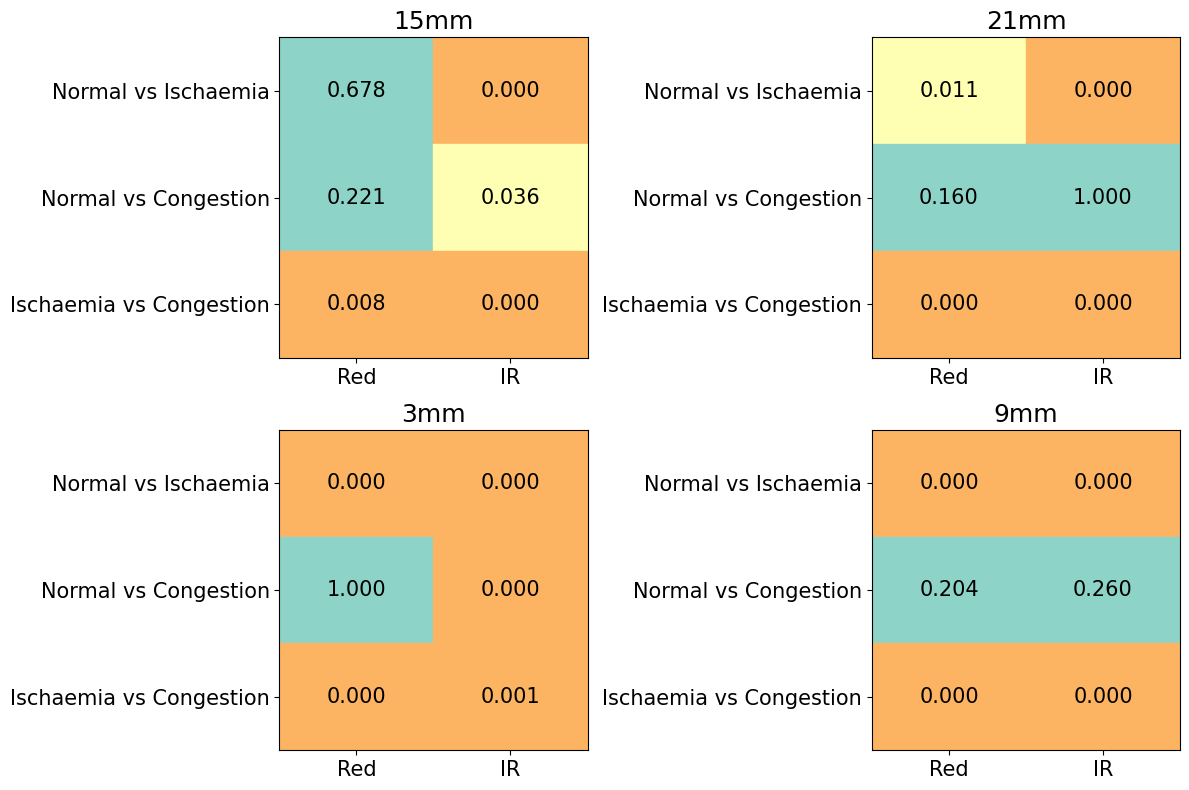

In [151]:
# 再度必要なパッケージをインポートしてコードを実行

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ファイル読み込み
df = pd.read_csv("dunn_posthoc_all_depths.csv")

# 深さごとのデータに分割
depths = df["Depth"].unique()
depths.sort()

# 比較軸とチャネルの順序を定義
comparisons = ["Normal vs Ischaemia", "Normal vs Congestion", "Ischaemia vs Congestion"]
channels = ["Red", "IR"]

# 色のマップ関数：p値に応じて色を設定
def get_color(p):
    if p < 0.01:
        return "#fdb462"  # 優しい青緑
    elif p < 0.05:
        return "#ffffb3"  # 優しい黄色
    else:
        return "#8dd3c7"  # 優しいオレンジ

# プロット準備
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, depth in enumerate(depths):
    ax = axes[idx]
    sub_df = df[df["Depth"] == depth]

    # 描画用マトリクス作成
    heatmap_data = pd.DataFrame(index=comparisons, columns=channels)

    for _, row in sub_df.iterrows():
        heatmap_data.loc[row["Comparison"], row["Channel"]] = row["p (Adjusted)"]

    # 数値のp値を float で保存し、色塗り用に用いる
    p_values = heatmap_data.astype(float)

    # 手動で heatmap 描画（p値に応じた背景色、文字重ね）
    for i, comp in enumerate(comparisons):
        for j, ch in enumerate(channels):
            p_val = p_values.loc[comp, ch]
            color = get_color(p_val)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
            ax.text(j + 0.5, i + 0.5, f"{p_val:.3f}", ha='center', va='center', fontsize=15)

    # 軸設定
    ax.set_xticks(np.arange(len(channels)) + 0.5)
    ax.set_yticks(np.arange(len(comparisons)) + 0.5)
    ax.set_xticklabels(channels, fontsize=15)
    ax.set_yticklabels(comparisons, fontsize=15)
    ax.set_xlim(0, len(channels))
    ax.set_ylim(0, len(comparisons))
    ax.set_title(f"{depth}", fontsize=18)
    ax.invert_yaxis()
    ax.set_aspect('auto')  # 自動で長方形化
    ax.grid(False)

plt.tight_layout()
plt.show()



In [152]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ========= パラメータ =========
fs = 2000           # サンプリングレート [Hz]
window_sec = 1      # 1秒ごとに分割
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
channels = {"ppgA_Red_AGC": "Red", "ppgA_IR_AGC": "IR"}

# ========= 1. データ読み込み & 振幅計算 (変更なし) =========
records = []
for depth in depths:
    # 実際にはここにファイルが存在する必要があります (例: 3mm_AGC_data1.csv)
    # ファイルが存在しない場合、このコードは実行時エラーになります。
    # 実行前に、適切なCSVファイルを用意してください。
    for key, state in state_map.items():
        file = f"{depth}mm_AGC_{key}.csv"
        try:
            df = pd.read_csv(file)
        except FileNotFoundError:
            print(f"Warning: File not found: {file}. Skipping.")
            continue

        for col, label in channels.items():
            sig = df[col].values
            step = fs * window_sec
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w*step, (w+1)*step
                seg = sig[s:e]
                if len(seg) < 5: 
                    continue
                amp = seg.max() - seg.min()
                mean = seg.mean()
                records.append({
                    "Depth": depth,
                    "State": state,
                    "Channel": label,
                    "Amplitude": amp,
                    "MeanValue": mean
                })

df_all = pd.DataFrame(records)

# データが全く読み込まれなかった場合のチェック
if df_all.empty:
    print("Error: No data was loaded. Please check your CSV file paths.")
    exit()

# ====================================================================
# ========= 2. 正規化（論文記述に合わせた修正版） =========
# RedはNormal 3mm Redの平均で、IRはNormal 3mm IRの平均でそれぞれ正規化する。
# ====================================================================

# 1. 基準となるベースライン振幅をチャンネルごとに計算
baseline_amps = {}
for ch in ["Red", "IR"]:
    mean_amp = df_all.query(f"State=='Normal' and Depth==3 and Channel=='{ch}'")["Amplitude"].mean()
    if pd.isna(mean_amp) or mean_amp == 0:
        print(f"Error: Baseline amplitude for Normal 3mm {ch} is zero or not found. Cannot normalize.")
        # ゼロ除算を避けるため、計算を続行しない
        exit() 
    baseline_amps[ch] = mean_amp

# 2. ベースラインをデータフレームにマッピング
def get_baseline(row):
    return baseline_amps.get(row["Channel"])

df_all["Baseline_Amp"] = df_all.apply(get_baseline, axis=1)

# 3. 正規化を実行
df_all["Amp_norm"] = df_all["Amplitude"] / df_all["Baseline_Amp"]

print("\n=== 正規化ベースライン値 ===")
for ch, amp in baseline_amps.items():
    print(f"Normal 3mm {ch} Mean Amplitude: {amp:.3f}")
print("===========================")

# ========= 3. AUC計算（ブートストラップCI付き） (変更なし) =========
pairs = [("Normal","Ischaemia"),("Normal","Congestion"),("Ischaemia","Congestion")]

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=200, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, len(y_true), len(y_true))
        # ブートストラップサンプル内でクラスが2つ未満の場合はスキップ
        if len(np.unique(y_true[idx])) < 2:
            continue
        # y_scoreが全て同じ値（例：全データポイントが同じ正規化振幅）の場合、ROCは計算できない
        if np.all(y_score[idx] == y_score[idx][0]):
             continue
        aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
    if not aucs:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 100*alpha/2), np.percentile(aucs, 100*(1-alpha/2))

results = []
for ch in ["Red","IR"]:
    for depth in depths:
        sub = df_all[(df_all.Channel==ch)&(df_all.Depth==depth)]
        for cls1, cls2 in pairs:
            df_sub = sub[sub.State.isin([cls1,cls2])]
            if df_sub.empty: 
                continue
            
            # クラスラベルとスコア
            y_true = (df_sub.State==cls1).astype(int).values
            y_score = df_sub["Amp_norm"].values
            
            # クラスが2つ未満の場合、またはスコアが全て同じ値の場合、スキップ
            if len(np.unique(y_true)) < 2 or np.all(y_score == y_score[0]): 
                # AUCは定義できないか、信頼区間の計算が不正確になる
                results.append({
                    "Channel": ch,
                    "Depth": depth,
                    "Pair": f"{cls1} vs {cls2}",
                    "AUC": np.nan,
                    "AUC_bootstrap_mean": np.nan,
                    "CI_lower": np.nan,
                    "CI_upper": np.nan,
                    "Cutoff": np.nan,
                    "Sensitivity": np.nan,
                    "Specificity": np.nan
                })
                continue
                
            auc = roc_auc_score(y_true, y_score)
            auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)
            fpr, tpr, thr = roc_curve(y_true, y_score)
            
            # 最適な閾値の決定（Youden's J statistic: Sensitivity + Specificity - 1）
            youden = tpr - fpr
            idx = np.argmax(youden)
            
            results.append({
                "Channel": ch,
                "Depth": depth,
                "Pair": f"{cls1} vs {cls2}",
                "AUC": auc,
                "AUC_bootstrap_mean": auc_bs,
                "CI_lower": ci_lo,
                "CI_upper": ci_hi,
                "Cutoff": thr[idx],
                "Sensitivity": tpr[idx],
                "Specificity": 1-fpr[idx]
            })

df_auc = pd.DataFrame(results)
print("\n=== ROC サマリ (Amplitude, bootstrapあり) ===")
print(df_auc.round(3))

# ========= 4. ROC 曲線プロット (変更なし) =========
def plot_roc(ch, depth, cls1, cls2):
    data = df_all[(df_all.Channel==ch)&(df_all.Depth==depth)&(df_all.State.isin([cls1,cls2]))]
    if data.empty:
        print("データなし")
        return
    y_true = (data.State==cls1).astype(int)
    y_score = data["Amp_norm"]

    if len(np.unique(y_true)) < 2 or np.all(y_score == y_score.iloc[0]):
        print(f"Cannot plot ROC for {ch} {depth}mm {cls1} vs {cls2}: insufficient data variability.")
        return

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{ch} {depth}mm {cls1} vs {cls2}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === DataFrame全行をCSVに保存 ===
df_auc.to_csv("ROC_summary_with_bootstrap_corrected.csv", index=False)
print("ROCサマリを 'ROC_summary_with_bootstrap_corrected.csv' として保存しました。")

# === 任意のプロット例 ===
# plot_roc("Red", 3, "Normal", "Ischaemia") 
# plot_roc("IR", 21, "Ischaemia", "Congestion")


=== 正規化ベースライン値 ===
Normal 3mm Red Mean Amplitude: 0.002
Normal 3mm IR Mean Amplitude: 0.004

=== ROC サマリ (Amplitude, bootstrapあり) ===
   Channel  Depth                     Pair    AUC  AUC_bootstrap_mean  \
0      Red      3      Normal vs Ischaemia  1.000               1.000   
1      Red      3     Normal vs Congestion  0.581               0.581   
2      Red      3  Ischaemia vs Congestion  0.000               0.000   
3      Red      9      Normal vs Ischaemia  0.834               0.837   
4      Red      9     Normal vs Congestion  0.313               0.311   
5      Red      9  Ischaemia vs Congestion  0.099               0.096   
6      Red     15      Normal vs Ischaemia  0.639               0.639   
7      Red     15     Normal vs Congestion  0.318               0.321   
8      Red     15  Ischaemia vs Congestion  0.323               0.339   
9      Red     21      Normal vs Ischaemia  0.749               0.751   
10     Red     21     Normal vs Congestion  0.324             

In [163]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score, roc_curve

# ========= 基本設定 =========
fs = 2000  # Hz
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
channels = {"ppgA_Red_AGC": "Red", "ppgA_IR_AGC": "IR"} 

# bpmテーブル（ユーザー提供値）
bpm_table = {
    3:  {"Normal": 60.8, "Ischaemia": 60.8, "Congestion": 62.3},
    9:  {"Normal": 62.7, "Ischaemia": 64.7, "Congestion": 64.3},
    15: {"Normal": 60.4, "Ischaemia": 60.8, "Congestion": 60.8},
    21: {"Normal": 65.1, "Ischaemia": 63.2, "Congestion": 63.2},
}

# ========= 拍動特徴抽出関数 (変更なし) =========
def extract_pulse_features(signal, fs, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs * dist))
    feats = []
    if len(peaks) < 2:
        return []

    for p in peaks:
        left = max(0, p - int(0.5 * fs))
        right = min(len(signal), p + int(0.5 * fs))
        seg = signal[left:right]
        
        if len(seg) < 5:
            continue
            
        peak_idx_in_seg = np.argmax(seg)
        trough_idx_in_seg = np.argmin(seg[:peak_idx_in_seg+1])
        next_trough_idx_in_seg = peak_idx_in_seg + np.argmin(seg[peak_idx_in_seg:])
        
        if trough_idx_in_seg < peak_idx_in_seg < next_trough_idx_in_seg:
            rise = (peak_idx_in_seg - trough_idx_in_seg) / fs
            fall = (next_trough_idx_in_seg - peak_idx_in_seg) / fs
            baseline = seg[trough_idx_in_seg]
            peak_val = seg[peak_idx_in_seg]
            
            half = baseline + 0.5 * (peak_val - baseline)
            segment_for_pw = seg[trough_idx_in_seg:next_trough_idx_in_seg+1] 
            above = np.where(segment_for_pw >= half)[0]
            pw = (above[-1] - above[0]) / fs if len(above) > 1 else np.nan
            
            amp = peak_val - baseline
            
            feats.append((rise, fall, pw, amp))
    return feats

# ========= データ読み込み & 特徴抽出 =========
records = []
pulse_id_counter = 0

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv") 
        try:
            df = pd.read_csv(file)
        except FileNotFoundError:
            # ファイルが見つからない場合は警告
            print(f"Warning: File not found: {file}. Skipping.")
            continue
            
        bpm = bpm_table[depth][state_name]
        window_sec = 60.0 / bpm
        step = int(round(fs * window_sec))

        for col, ch_label in channels.items():
            sig = df[col].values
            
            # (1) 1拍ごとのAmplitude計算（最大-最小）
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                if len(seg) < 5:
                    continue
                amp = seg.max() - seg.min()
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter, 
                    "RiseTime": np.nan, "FallTime": np.nan, 
                    "PulseWidth": np.nan, "Amplitude": amp 
                })
                
            # (2) find_peaksで特徴抽出
            feats = extract_pulse_features(sig, fs)
            for r, f, pw, amp in feats:
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter, 
                    "RiseTime": r, "FallTime": f, 
                    "PulseWidth": pw, "Amplitude": amp 
                })
            
            pulse_id_counter += 1

df_feat = pd.DataFrame(records)

if df_feat.empty:
    print("Error: No data was loaded. Please check your CSV file paths and names (using '*AGC*' files).")
    exit()

# ========= 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime"] / (df_feat["FallTime"] + 1e-6)
df_feat["Pulse_Area"] = df_feat["PulseWidth"] * df_feat["Amplitude"] 

# ========= 正規化 =========
def normalize_channel(df, ch):
    """チャンネルごとにNormal 3mmの平均Amplitudeで正規化する"""
    base_amp = df.query("Channel==@ch and Depth==3 and State=='Normal'")["Amplitude"].mean()
    if pd.isna(base_amp) or base_amp == 0:
        print(f"Error: Baseline amplitude for Normal 3mm {ch} is zero or not found.")
        df.loc[df.Channel == ch, "Amp_norm"] = np.nan
        return False
    df.loc[df.Channel == ch, "Amp_norm"] = df.loc[df.Channel == ch, "Amplitude"] / base_amp
    return True

# Amplitude の正規化を実行
normalize_channel(df_feat, "Red")
normalize_channel(df_feat, "IR")

df_feat["Pulse_Area_norm"] = df_feat["PulseWidth"] * df_feat["Amp_norm"]

# ========= Red/IR比の計算のためのデータ前処理 =========

amp_data = df_feat.dropna(subset=['Amplitude', 'Amp_norm']).copy()

df_red = amp_data[amp_data.Channel == "Red"].rename(
    columns={"Amplitude": "Amplitude_Red", "Amp_norm": "Amp_norm_Red"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_Red', 'Amp_norm_Red']]

df_ir = amp_data[amp_data.Channel == "IR"].rename(
    columns={"Amplitude": "Amplitude_IR", "Amp_norm": "Amp_norm_IR"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_IR', 'Amp_norm_IR']]

# Depth, State, Pulse_ID をキーとして結合（対応する脈波ペアのみ残す）
df_ratio = pd.merge(
    df_red,
    df_ir,
    on=['Depth', 'State', 'Pulse_ID'],
    how='inner' 
)

# 2. Red/IR比を計算
df_ratio["Red_IR_amp_ratio"] = df_ratio["Amplitude_Red"] / (df_ratio["Amplitude_IR"] + 1e-6)
df_ratio["Red_IR_amp_norm_ratio"] = df_ratio["Amp_norm_Red"] / (df_ratio["Amp_norm_IR"] + 1e-6)


# ========= ROC AUC計算 (ブートストラップ付) =========
pairs = [("Normal", "Ischaemia"), ("Normal", "Congestion"), ("Ischaemia", "Congestion")]
features_to_eval = [
    "Amp_norm", 
    "RiseTime", "FallTime", "PulseWidth", 
    "RiseFall_ratio", 
    "Pulse_Area", 
]
ratio_features_to_eval = ["Red_IR_amp_ratio", "Red_IR_amp_norm_ratio"] 

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=50, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        if len(np.unique(y_true[idx])) < 2 or np.all(y_score[idx] == y_score[idx][0]):
            continue
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
            
    if len(aucs) == 0:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)

rows = []

# --- 1. チャンネルごとの特徴量の処理 ---
for ch in ["Red", "IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel == ch) & (df_feat.Depth == depth)]
        if sub.empty:
            continue
        
        for feature in features_to_eval:
            for cls1, cls2 in pairs:
                d = sub[sub.State.isin([cls1, cls2])]
                if d.empty:
                    continue

                # --- NaN 除外 ---
                y_true = (d["State"] == cls1).astype(int).values
                y_score = d[feature].values
                mask = ~np.isnan(y_score)
                y_true = y_true[mask]
                y_score = y_score[mask]
                # サンプルサイズとクラス変動のチェック
                if len(y_true) < 10 or len(np.unique(y_true)) < 2 or np.all(y_score == y_score[0]):
                    continue

                auc_point = roc_auc_score(y_true, y_score)
                auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)
                
                # 最適な閾値の計算
                fpr, tpr, thr = roc_curve(y_true, y_score)
                youden = tpr - fpr
                idx = np.argmax(youden)
                cutoff = thr[idx]
                sens = tpr[idx]
                spec = 1 - fpr[idx]

                rows.append({
                    "Channel": ch,
                    "Depth": depth,
                    "Feature": feature,
                    "Pair": f"{cls1} vs {cls2}",
                    "AUC": auc_point,
                    "AUC_bootstrap_mean": auc_bs,
                    "CI_lower": ci_lo,
                    "CI_upper": ci_hi,
                    "Cutoff": cutoff,
                    "Sensitivity": sens,
                    "Specificity": spec,
                    "n_samples": len(y_true)
                })

# --- 2. Red/IR比の特徴量の処理 ---
for depth in depths:
    sub_ratio = df_ratio[df_ratio.Depth == depth]
    if sub_ratio.empty:
        # 比率データが空の場合、警告を出力
        print(f"Warning: No valid Red/IR ratio data found for Depth {depth}mm.")
        continue
    
    for feature in ratio_features_to_eval:
        for cls1, cls2 in pairs:
            d = sub_ratio[sub_ratio.State.isin([cls1, cls2])]
            if d.empty:
                continue

            # --- NaN 除外 ---
            y_true = (d["State"] == cls1).astype(int).values
            y_score = d[feature].values
            mask = ~np.isnan(y_score)
            y_true = y_true[mask]
            y_score = y_score[mask]
            # サンプルサイズとクラス変動のチェック
            if len(y_true) < 10 or len(np.unique(y_true)) < 2 or np.all(y_score == y_score[0]):
                continue

            auc_point = roc_auc_score(y_true, y_score)
            auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)

            fpr, tpr, thr = roc_curve(y_true, y_score)
            youden = tpr - fpr
            idx = np.argmax(youden)
            cutoff = thr[idx]
            sens = tpr[idx]
            spec = 1 - fpr[idx]

            rows.append({
                "Channel": "Red/IR_Ratio", 
                "Depth": depth,
                "Feature": feature,
                "Pair": f"{cls1} vs {cls2}",
                "AUC": auc_point,
                "AUC_bootstrap_mean": auc_bs,
                "CI_lower": ci_lo,
                "CI_upper": ci_hi,
                "Cutoff": cutoff,
                "Sensitivity": sens,
                "Specificity": spec,
                "n_samples": len(y_true)
            })


df_auc_feat = pd.DataFrame(rows)
df_auc_feat.to_csv("AUC_all_features_95CI_final_RedIRRatio.csv", index=False)
print("Saved AUC_all_features_95CI_final_RedIRRatio.csv")

# 比率の結果が確認しやすいように、Channel 'Red/IR_Ratio' の行のみを表示します。
df_ratio_results = df_auc_feat[df_auc_feat['Channel'] == 'Red/IR_Ratio']
if not df_ratio_results.empty:
    print("\n--- Red/IR Ratio Results Confirmation ---")
    print(df_ratio_results.round(3))
else:
    print("\n--- Red/IR Ratio Results Confirmation ---")
    print("Warning: No Red/IR Ratio results were generated. This indicates insufficient corresponding data pairs (Red and IR) in the source files to meet the minimum sample size requirement (n=10) for AUC calculation.")

Saved AUC_all_features_95CI_final_RedIRRatio.csv

--- Red/IR Ratio Results Confirmation ---


/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/3335437166.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


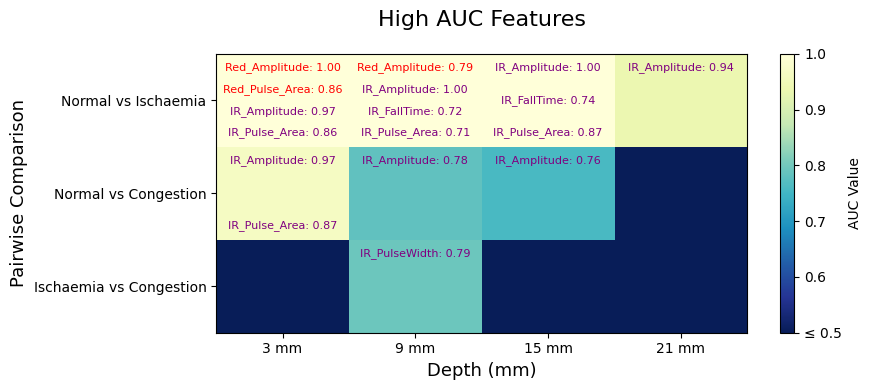

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========

# 最終的に生成されたAUCサマリーファイル名を指定（必要に応じて変更してください）
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio.csv"
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please run the previous code block to generate the CSV.")
    exit()

# NaN値を含む行を削除し、AUC値が0.7未満のものは無視する
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.7].copy() # プロット対象（AUC>0.7）のみ

# ========= 2. 特徴量の整形と色の定義 =========

# 2.1. 特徴名のマッピングと結合
def format_feature_name(row):
    feature = row['Feature']
    channel = row['Channel']
    
    # Amp_normをAmplitudeに改名
    if feature == 'Amp_norm':
        feature = 'Amplitude'
        
    # Pulse_Area_normはPulse_Areaと同一とみなし削除（Noneを返すことでフィルタリング）
    if feature == 'Pulse_Area_norm':
        return None
        
    # ChannelとFeatureを結合 
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        # Ratioの場合はFeature名をそのまま使用（例: Red_IR_amp_norm_ratio）
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

# 2.2. 色の定義
def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

# 2.3. ヒートマップ描画用データフレームの準備
# 縦軸のペアの順序を定義
pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion',
    'Ischaemia vs Congestion'
]
# 横軸のDepthの順序を定義
depth_order = sorted(df_filtered_plot['Depth'].unique())

# グリッドの各セルに表示するテキストと背景色の値を準備
text_grid = {} # key: (Pair, Depth), value: [(text, color, auc_value), ...]
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

for index, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']
    
    key = (pair, depth)
    
    # テキスト準備
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)
    
    if key not in text_grid:
        text_grid[key] = []
    text_grid[key].append((text, color, auc_value))
    
    # 背景色の基準（セル内の最大AUC）を更新
    if pair in pair_order and depth in depth_order:
        current_max = heatmap_values.loc[pair, depth]
        if pd.isna(current_max) or auc_value > current_max:
            heatmap_values.loc[pair, depth] = auc_value


# AUCが0.7未満（プロット対象外）のセルは、カラーマップの最小値（0.5）で埋める
MIN_AUC_FOR_CMAP = 0.5 
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP) 

# ========= 3. ヒートマップのプロット =========

fig, ax = plt.subplots(figsize=(9, 4)) # figsizeを少し大きく調整

# 3.1. 背景色 (AUCが高いほど明るい色、青を0.5付近に)
cmap = plt.cm.get_cmap('YlGnBu_r') 
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0) 

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 3.2. 軸の設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order])
ax.set_yticklabels(pair_order)

ax.set_xlabel('Depth (mm)', fontsize=13)
ax.set_ylabel('Pairwise Comparison', fontsize=13)
ax.set_title(f'High AUC Features', fontsize=16, pad=20)

# 3.3. テキストの描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        
        # AUC > 0.7のデータがあるセルのみにテキストを描画
        if key in text_grid and heatmap_values.loc[pair, depth] > 0.7:
            entries = [(t, c) for t, c, a in text_grid[key]] # (text, color) のみを使用
            
            # セル内のテキスト配置を調整
            n_entries = len(entries)
            
            # 垂直方向の中心から上下にずらして配置
            y_offsets = np.linspace(-0.35, 0.35, n_entries)
            
            for k, (text, color) in enumerate(entries):
                ax.text(j, i + y_offsets[k],
                        text, 
                        ha="center", 
                        va="center", 
                        color=color, 
                        fontsize=8, 
                        linespacing=1.2)

# 3.4. カラーバーの追加と修正
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')

# Y軸のラベルを設定
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
# 最小値のラベルをカスタマイズ (AUC <= 0.5)
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'

# Y軸の目盛りラベルを設定（これが正しい方法）
cbar.ax.set_yticklabels(custom_labels) 

# ★ エラーの原因となっていた X軸のラベル設定を削除 ★
# cbar.ax.set_xticklabels(...) # この行を削除

plt.tight_layout()
plt.show()

<>:115: SyntaxWarning: invalid escape sequence '\g'
<>:115: SyntaxWarning: invalid escape sequence '\g'
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/1468831381.py:115: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f'High AUC Features (Max AUC $\geq$ {MIN_AUC_FOR_CMAP:.1f} used for background color)', fontsize=16, pad=20)
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_98863/1468831381.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


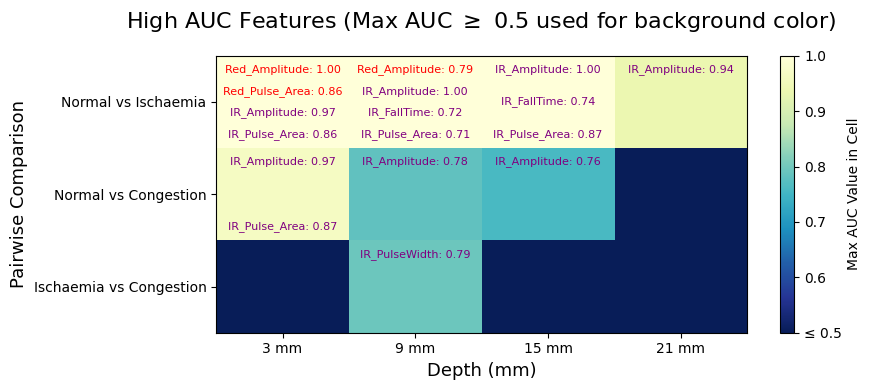